# Version 3.2 - use nested cross validation and compare different FS methods and use 2/8 split

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import model_selection, feature_selection, ensemble, linear_model, metrics
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn_relief as relief
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Sequential
import pickle, os, joblib
import time
from PyImpetus import PPIMBR

2022-12-12 15:55:03.399564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#read in dataset for training
df = pd.read_excel("trainDataset.xls")
#drop ID column
df.drop('ID', axis=1, inplace=True)
#rename outcome columns to a shorter name
df= df.rename(columns={"RelapseFreeSurvival (outcome)":"Y_reg", "pCR (outcome)":"Y_clf"}) 
df.head()

Y_clf  Y_reg   Age  ER  PgR  HER2  TrippleNegative  ChemoGrade  \
0      1  144.0  41.0   0  0.0   0.0              1.0           3   
1      0  142.0  39.0   1  1.0   0.0              0.0           3   
2      1  135.0  31.0   0  0.0   0.0              1.0           2   
3      0   12.0  35.0   0  0.0   0.0              1.0           3   
4      0  109.0  61.0   1  0.0   0.0              0.0           2   

   Proliferation  HistologyType  ...  \
0              3              1  ...   
1              3              1  ...   
2              1              1  ...   
3              3              1  ...   
4              1              1  ...   

   original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                       0.517172   
1                                       0.444391   
2                                       0.534549   
3                                       0.506185   
4                                       0.462282   

   original_glszm_SmallAreaLowGrayLevelEmphasis  original_glszm_ZoneEntropy  \
0                                      0.375126                    3.325332   
1                                      0.444391                    3.032144   
2                                      0.534549                    2.485848   
3                                      0.506185                    2.606255   
4                                      0.462282                    2.809279   

   original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
0                       0.002314                  3880771.500   
1                       0.005612                  2372009.744   
2                       0.006752                  1540027.421   
3                       0.003755                  6936740.794   
4                       0.006521                  1265399.054   

   original_ngtdm_Busyness  original_ngtdm_Coarseness  \
0               473.464852                   0.000768   
1                59.459710                   0.004383   
2                33.935384                   0.007584   
3                46.859265                   0.005424   
4                39.621023                   0.006585   

   original_ngtdm_Complexity  original_ngtdm_Contrast  original_ngtdm_Strength  
0                   0.182615                 0.030508                 0.000758  
1                   0.032012                 0.001006                 0.003685  
2                   0.024062                 0.000529                 0.006447  
3                   0.013707                 0.000178                 0.004543  
4                   0.034148                 0.001083                 0.005626  

[5 rows x 119 columns]

---
# Missing value & outliners dealing

In [3]:
#outliers detection and transform outliers to nan for later processing
from scipy import stats
categoricalTitles = ['Y_clf','ER','PgR','HER2','TrippleNegative','ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage']
for c in df.columns:
    if c in categoricalTitles:
        continue
    q1Pos = 0.1
    q3Pos = 0.9
    q1=df[c].quantile(q1Pos)
    q3=df[c].quantile(q3Pos)
    IQR=q3-q1
    upper_limit = q3+1.5*IQR
    lower_limit = q1-1.5*IQR
    outliers = df[c][((df[c]<(q1-1.5*IQR)) | (df[c]>(q3+1.5*IQR)))]
    
    df[c] = df[c].apply(lambda x : np.where(x > upper_limit, np.nan, np.where(x < lower_limit, np.nan, x)))

In [4]:
#replace 999 to nan
df = df.replace(999,np.nan)
df.columns[df.isna().any()].tolist()

['Y_clf',
 'PgR',
 'HER2',
 'TrippleNegative',
 'ChemoGrade',
 'Proliferation',
 'HistologyType',
 'LNStatus',
 'original_shape_LeastAxisLength',
 'original_shape_MajorAxisLength',
 'original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum2DDiameterSlice',
 'original_shape_Maximum3DDiameter',
 'original_shape_MeshVolume',
 'original_shape_MinorAxisLength',
 'original_shape_SurfaceArea',
 'original_shape_VoxelVolume',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_Median',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Variance',
 'original_glcm_Autocorrelation',
 'original_glcm_ClusterShade',
 'original_glcm_Contrast',
 'original_glcm_DifferenceAverage',
 'original_glcm_Id',
 'original_glcm_Idm',
 'original_glcm_Idmn',
 'original_glcm_Idn',
 'original_glcm_Imc1',
 'orig

0


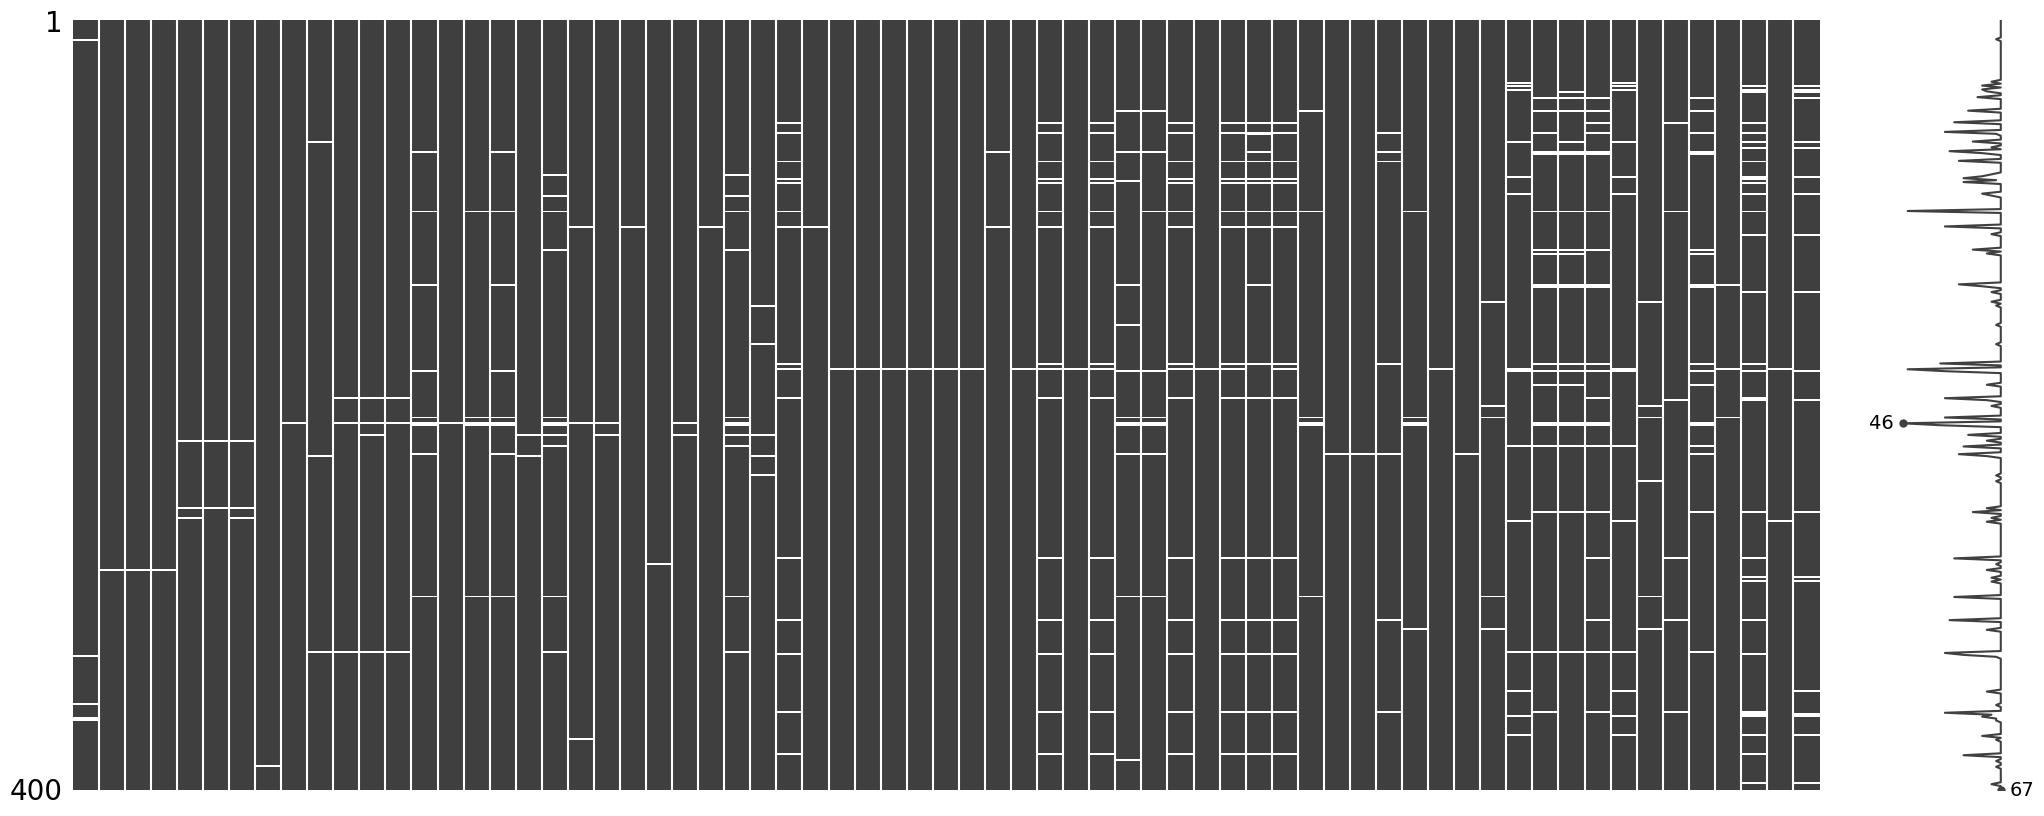

In [5]:
#use KNN imputer for nan filling (same for outliers)
import missingno as msno
null_cols = df.columns[df.isnull().any()]
msno.matrix(df[null_cols])

#knn imputer

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)

result = imputer.fit_transform(df)
nonNulldataFrame = pd.DataFrame(result, columns= df.columns.tolist())
nonNulldataFrame = nonNulldataFrame[null_cols].apply(lambda x: round(x))
df = df.drop(null_cols, axis=1)
df = pd.concat([df, nonNulldataFrame], axis=1)
#checking for missing
#nonNulldataFrame.to_csv("test.csv")
print(nonNulldataFrame.isnull().sum().sum())

In [6]:
df.head()

Y_reg   Age  ER  TumourStage  original_shape_Elongation  \
0  144.0  41.0   0            2                   0.813912   
1  142.0  39.0   1            2                   0.666118   
2  135.0  31.0   0            2                   0.645083   
3   12.0  35.0   0            3                   0.770842   
4  109.0  61.0   1            2                   0.861035   

   original_shape_Flatness  original_shape_Maximum2DDiameterColumn  \
0                 0.724080                               37.696154   
1                 0.476173                               51.971146   
2                 0.594470                               32.984845   
3                 0.501228                               66.910388   
4                 0.750267                               33.241540   

   original_shape_Sphericity  original_shape_SurfaceVolumeRatio  \
0                   0.771675                           0.258736   
1                   0.603481                           0.330900   
2                   0.608183                           0.359083   
3                   0.474509                           0.340781   
4                   0.756228                           0.309200   

   original_firstorder_10Percentile  ...  \
0                         -0.163500  ...   
1                          0.665558  ...   
2                          0.638035  ...   
3                          0.759496  ...   
4                          0.434385  ...   

   original_glszm_LargeAreaHighGrayLevelEmphasis  \
0                                     15655225.0   
1                                      9614769.0   
2                                      6247801.0   
3                                     28030626.0   
4                                      5155465.0   

   original_glszm_LargeAreaLowGrayLevelEmphasis  \
0                                     1170667.0   
1                                      601003.0   
2                                      390504.0   
3                                     1751932.0   
4                                      322276.0   

   original_glszm_LowGrayLevelZoneEmphasis  \
0                                      1.0   
1                                      1.0   
2                                      1.0   
3                                      1.0   
4                                      1.0   

   original_glszm_SizeZoneNonUniformity  \
0                                   6.0   
1                                  16.0   
2                                  20.0   
3                                  26.0   
4                                  13.0   

   original_glszm_SizeZoneNonUniformityNormalized  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   original_glszm_ZoneVariance  original_ngtdm_Busyness  \
0                    3880772.0                    473.0   
1                    2372010.0                     59.0   
2                    1540027.0                     34.0   
3                    6936741.0                     47.0   
4                    1265399.0                     40.0   

   original_ngtdm_Coarseness  original_ngtdm_Contrast  original_ngtdm_Strength  
0                        0.0                      0.0                      0.0  
1                        0.0                      0.0                      0.0  
2                        0.0                      0.0                      0.0  
3                        0.0                      0.0                      0.0  
4                        0.0                      0.0                      0.0  

[5 rows x 119 columns]

---
# Normalisation using MinMaxScaler

In [7]:
## MinMaxscaler for non-categorical features
cols = ['Y_clf','ER','PgR','HER2','TrippleNegative','ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage','Y_reg']
df_num = df.drop(cols, axis=1)
scalar = MinMaxScaler((0,1))
df_cols = df_num.columns.tolist()
scaled_data = pd.DataFrame(scalar.fit_transform(df_num), columns=df_cols)
df_pca = pd.concat([df[cols], scaled_data], axis=1)
df_pca

Y_clf  ER  PgR  HER2  TrippleNegative  ChemoGrade  Proliferation  \
0      1.0   0  0.0   0.0              1.0         3.0            3.0   
1      0.0   1  1.0   0.0              0.0         3.0            3.0   
2      1.0   0  0.0   0.0              1.0         2.0            1.0   
3      0.0   0  0.0   0.0              1.0         3.0            3.0   
4      0.0   1  0.0   0.0              0.0         2.0            1.0   
..     ...  ..  ...   ...              ...         ...            ...   
395    1.0   0  0.0   0.0              1.0         3.0            3.0   
396    0.0   0  0.0   0.0              1.0         2.0            1.0   
397    0.0   1  0.0   0.0              0.0         3.0            3.0   
398    0.0   1  0.0   0.0              0.0         2.0            1.0   
399    1.0   0  0.0   1.0              0.0         2.0            1.0   

     HistologyType  LNStatus  TumourStage  ...  \
0              1.0       1.0            2  ...   
1              1.0       1.0            2  ...   
2              1.0       0.0            2  ...   
3              1.0       1.0            3  ...   
4              1.0       0.0            2  ...   
..             ...       ...          ...  ...   
395            1.0       1.0            4  ...   
396            1.0       0.0            2  ...   
397            1.0       1.0            3  ...   
398            1.0       1.0            2  ...   
399            1.0       0.0            2  ...   

     original_glszm_LargeAreaHighGrayLevelEmphasis  \
0                                         0.047302   
1                                         0.028781   
2                                         0.018457   
3                                         0.085247   
4                                         0.015108   
..                                             ...   
395                                       0.211062   
396                                       0.002798   
397                                       0.254721   
398                                       0.006453   
399                                       0.018977   

     original_glszm_LargeAreaLowGrayLevelEmphasis  \
0                                        0.039277   
1                                        0.019925   
2                                        0.012774   
3                                        0.059022   
4                                        0.010457   
..                                            ...   
395                                      0.146344   
396                                      0.001930   
397                                      0.179030   
398                                      0.004462   
399                                      0.013161   

     original_glszm_LowGrayLevelZoneEmphasis  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
..                                       ...   
395                                      0.0   
396                                      0.0   
397                                      0.0   
398                                      0.0   
399                                      0.0   

     original_glszm_SizeZoneNonUniformity  \
0                                0.080645   
1                                0.241935   
2                                0.306452   
3                                0.403226   
4                                0.193548   
..                                    ...   
395                              0.080645   
396                              0.016129   
397                              0.048387   
398                              0.161290   
399                              0.225806   

     original_glszm_SizeZoneNonUniformityNormalized  \
0                                               0.0   
1            

In [83]:
####comment section reference for model save and load#####
## save & load model
## joblib.dump(Lmodel, "Lreg_not_nested.pkl")
## joblib.load('Lreg_not_nested.pkl')

####Ann keras save & load
# """
# model_json = model.to_json()
# with open('model.json', 'w') as json_file:
#     json_file.write(model_json)
# model.save_weights('model.h5')

# json_file = open('model.json')
# loaded_model = json_file.read()
# json_file.close()

# loaded_model = model_from_json(loaded_model)
# loaded_model.loaded_weights('model.h5')

# loaded_model.compile()
# score = loaded_model.evaluate()
# """

# """ keras save
# model.save('my_model')

# model = keras.model.load_model('my_model')
# """

---
## PCA only 

In [29]:
#pca set up
data,Y_reg, Y_clf = df_pca.drop(columns =['Y_reg','Y_clf'], axis=1), df_pca['Y_reg'], df_pca['Y_clf']
pca = PCA(n_components = 0.95, svd_solver='full')
pca.fit(data)
data_pca = pca.transform(data)
data_pca.shape

(400, 22)

In [30]:
cols = []
i = 1
while i <=22:
    cols.append('PCA_{}'.format(i))
    i +=1
df_pca_only = pd.DataFrame(data_pca, columns=cols)
df_pca_only = pd.concat([Y_clf, Y_reg, df_pca_only], axis=1)
df_pca_only

Y_clf       Y_reg     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5  \
0      1.0  144.000000  2.442751  1.297723 -0.514492  0.237486  0.002468   
1      0.0  142.000000  0.062368  0.830775  1.034049  1.431147  0.273470   
2      1.0  135.000000  0.056736 -0.255353  1.004211 -1.089460  0.524865   
3      0.0   12.000000 -0.516739  1.978758  0.923670 -0.052461 -0.017084   
4      0.0  109.000000  0.064618 -0.752534  0.756667  0.022752  0.724013   
..     ...         ...       ...       ...       ...       ...       ...   
395    1.0   49.250000 -0.759545  2.130227 -0.265857 -0.261476 -0.948876   
396    0.0   48.500000  0.133397 -0.756292  1.273401 -1.424482 -1.232477   
397    0.0   47.500000  0.055419  1.554263 -0.048637  0.993606  0.321378   
398    0.0   46.916667 -0.339705 -1.041866  0.826906 -0.178687 -0.469398   
399    1.0   46.750000  0.381200 -0.783962  0.205447 -0.605353  0.126728   

        PCA_6     PCA_7     PCA_8  ...    PCA_13    PCA_14    PCA_15  \
0    0.794817 -0.239635 -0.354868  ... -0.877661  0.094474 -0.381322   
1   -0.135373  0.279894 -0.697262  ... -0.004318 -0.176481 -0.343630   
2   -0.528660 -0.656075 -0.010998  ... -0.142532 -0.066455 -0.386711   
3   -0.260560 -0.330414 -0.467976  ... -0.146745 -0.114797 -0.272359   
4   -0.401869 -0.594968  0.199886  ...  0.361866  0.698051 -0.244684   
..        ...       ...       ...  ...       ...       ...       ...   
395  0.030951 -0.021677 -0.353979  ... -0.450454 -0.083114  0.206578   
396  0.054018 -0.084111  0.006656  ...  0.196009  0.203918 -0.080186   
397  0.584665 -0.136457 -0.006490  ...  0.268731  0.304369  0.078696   
398 -0.478405  0.050561 -0.667541  ...  0.053012  0.580538  0.155868   
399 -0.816154  0.239775  0.674978  ...  0.167780 -0.210927  0.187339   

       PCA_16    PCA_17    PCA_18    PCA_19    PCA_20    PCA_21    PCA_22  
0   -0.071938 -0.480455  0.410302  0.044492  0.336320  0.039131 -0.136473  
1    0.095560 -0.081895  0.251545 -0.017975 -0.057011  0.086886 -0.124022  
2    0.142366 -0.125077  0.083314 -0.143281 -0.039731 -0.140469 -0.149941  
3   -0.132908 -0.080165  0.272663  0.031717  0.109212 -0.127896 -0.110593  
4    0.131229 -0.201005 -0.221109  0.035422 -0.194433  0.089417 -0.160000  
..        ...       ...       ...       ...       ...       ...       ...  
395  0.139684  0.258481  0.318263  0.184633 -0.002751 -0.048072  0.009244  
396 -0.238618  0.255986  0.061054 -0.162951  0.042471  0.022819  0.068485  
397  0.558105  0.296146 -0.107423  0.409631 -0.441697  0.064663  0.181259  
398  0.274916 -0.052295  0.027219 -0.295630 -0.060556  0.000984 -0.085331  
399  0.118597  0.071444  0.077041 -0.083569 -0.149694  0.289999 -0.022150  

[400 rows x 24 columns]

In [32]:
#split X and y
X = df_pca_only.drop(['Y_clf','Y_reg'], axis=1).values
y = df_pca_only['Y_reg'].values

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits


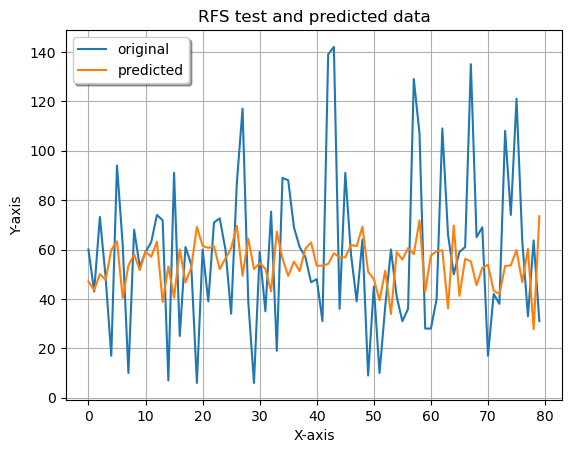

Lreg best param: {'fit_intercept': True}
Lreg MAE score: 25.974093637374516

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits


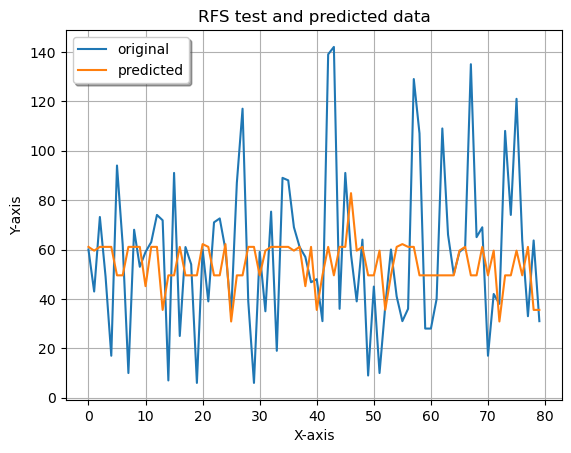

DTreg best param: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 9}
DTreg MAE score: 25.226834529751102

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits


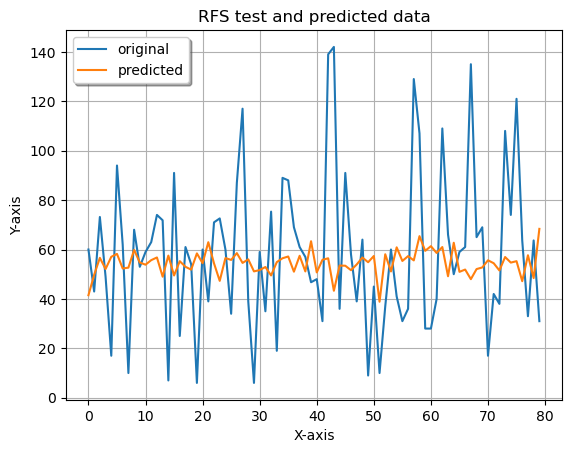

SVMreg best param: {'C': 6, 'gamma': 'scale', 'kernel': 'rbf'}
SVMreg MAE score: 25.541090190660725

--------------------------------------------------------
bestModel: GridSearchCV(cv=KFold(n_splits=10, random_state=8, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 9, 12],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'min_samples_leaf': [3, 6, 9]},
             verbose=1)
bestParam: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 9}
bestScore: 25.226834529751102


In [33]:
""" PCA only nested cross validation """

def cross_val(estimator, X_train, y_train, parameters, inner_cv, outer_cv):
    best_model = None
    best_params = None
    best_score = 100
    for train, test in outer_cv.split(X_train):
        # training and validation
        X_outer_train = X_train[train]
        y_outer_train = y_train[train]
        X_outer_test = X_train[test]
        y_outer_test = y_train[test]

        model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=None, verbose=1)
        #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=5, verbose=3)
        model.fit(X_outer_train, y_outer_train)
        # evaluate the accuracy of each fold
        prediction = model.predict(X_outer_test)
        score = metrics.mean_absolute_error(y_outer_test, prediction) # use mse as metrics in K-fold, np.array(y_test), verbose=0)

        if best_score > score:
            best_score = score
            best_model = model
            best_params = model.best_params_
    return best_score, best_model, best_params

def plot_draw(y_best, y_pred):
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)    
bestModel = None
bestParam = None
bestScore = 100

################################################################################

#hyper parameter tuning for LinearRegression
lreg_parameters = {"fit_intercept":[True,False]}

## call model
Lreg = linear_model.LinearRegression()

train_score, estimator, param = cross_val(Lreg, X_train, y_train, lreg_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "Lreg_pca_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore:
    bestModel = estimator
    bestScore = score
    bestParam = param

# print("Lreg trained MAE best score: {}".format(train_score))
print("Lreg best param: {}".format(param))
# print("Lreg best estimator: {}".format(estimator))
print("Lreg MAE score: {}\n".format(score))


################################################################################

#hyper parameter tuning for Decision Tree
dt_parameters = {"max_depth" : [3,9,12],
           "min_samples_leaf":[3,6,9],
           "max_features":["auto","log2","sqrt",None]}

## call model
DTreg = DecisionTreeRegressor()

train_score, estimator, param = cross_val(DTreg, X_train, y_train, dt_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "DTreg_nested_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore:
    bestModel = estimator
    bestScore = score
    bestParam = param

# print("DTreg trained MAE best score: {}".format(train_score))
print("DTreg best param: {}".format(param))
# print("DTreg best estimator: {}".format(estimator))
print("DTreg MAE score: {}\n".format(score))

################################################################################

#hyper parameter tuning for SVM
svm_parameters = {"kernel":['rbf', 'sigmoid'],
           "gamma":[0.1,1.0,10.0,'scale','auto'],
           "C": [1,2,3,4,5,6]}

## call model
SVMreg = svm.SVR()

train_score, estimator, param = cross_val(SVMreg, X_train, y_train, svm_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "SVMreg_nested_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore:
    bestModel = estimator
    bestScore = score
    bestParam = param

# print("SVMreg trained MAE best score: {}".format(train_score))
print("SVMreg best param: {}".format(param))
# print("SVMreg best estimator: {}".format(estimator))
print("SVMreg MAE score: {}\n".format(score))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel))
print("bestParam: {}".format(bestParam))
print("bestScore: {}".format(bestScore))

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits


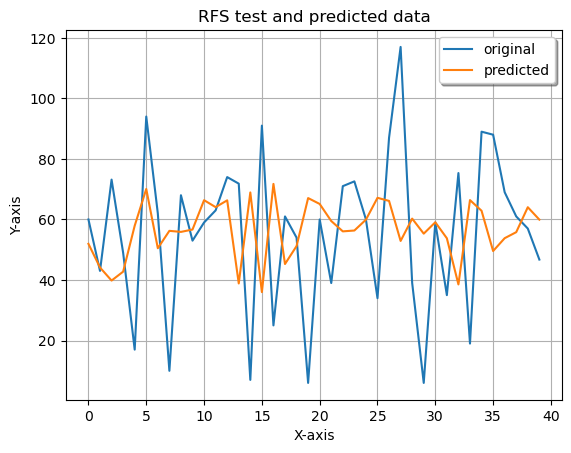

Lreg best param: {'fit_intercept': True}
Lreg MAE score: 23.331362141918266

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits


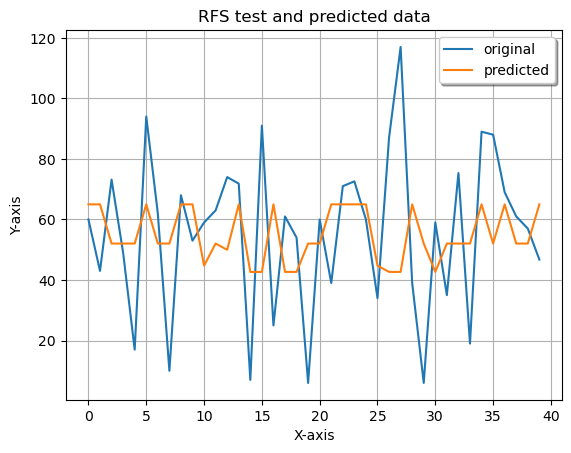

DTreg best param: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 6}
DTreg MAE score: 21.944494183142062

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits


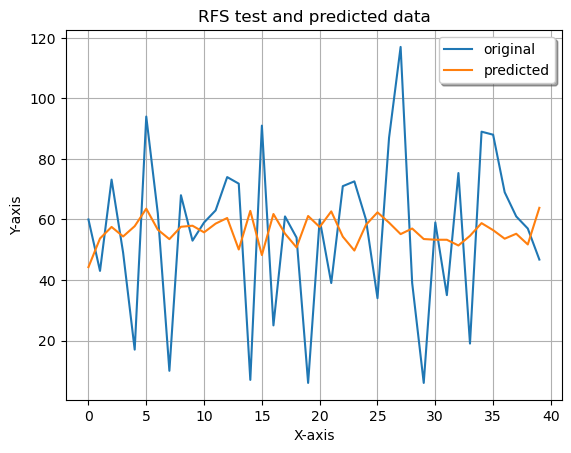

SVMreg best param: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
SVMreg MAE score: 21.631399220404592

--------------------------------------------------------
bestModel: GridSearchCV(cv=KFold(n_splits=10, random_state=8, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [1, 2, 3, 4, 5, 6],
                         'gamma': [0.1, 1.0, 10.0, 'scale', 'auto'],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=1)
bestParam: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
bestScore: 21.631399220404592


In [34]:
""" PCA only nested cross validation 1/9 split"""

def cross_val(estimator, X_train, y_train, parameters, inner_cv, outer_cv):
    best_model = None
    best_params = None
    best_score = 100
    for train, test in outer_cv.split(X_train):
        # training and validation
        X_outer_train = X_train[train]
        y_outer_train = y_train[train]
        X_outer_test = X_train[test]
        y_outer_test = y_train[test]

        model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=None, verbose=1)
        #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=5, verbose=3)
        model.fit(X_outer_train, y_outer_train)
        # evaluate the accuracy of each fold
        prediction = model.predict(X_outer_test)
        score = metrics.mean_absolute_error(y_outer_test, prediction) # use mse as metrics in K-fold, np.array(y_test), verbose=0)

        if best_score > score:
            best_score = score
            best_model = model
            best_params = model.best_params_
    return best_score, best_model, best_params

def plot_draw(y_best, y_pred):
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)    
bestModel = None
bestParam = None
bestScore = 100

################################################################################

#hyper parameter tuning for LinearRegression
lreg_parameters = {"fit_intercept":[True,False]}

## call model
Lreg = linear_model.LinearRegression()

train_score, estimator, param = cross_val(Lreg, X_train, y_train, lreg_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "Lreg_pca_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore:
    bestModel = estimator
    bestScore = score
    bestParam = param

# print("Lreg trained MAE best score: {}".format(train_score))
print("Lreg best param: {}".format(param))
# print("Lreg best estimator: {}".format(estimator))
print("Lreg MAE score: {}\n".format(score))


################################################################################

#hyper parameter tuning for Decision Tree
dt_parameters = {"max_depth" : [3,9,12],
           "min_samples_leaf":[3,6,9],
           "max_features":["auto","log2","sqrt",None]}

## call model
DTreg = DecisionTreeRegressor()

train_score, estimator, param = cross_val(DTreg, X_train, y_train, dt_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "DTreg_nested_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore:
    bestModel = estimator
    bestScore = score
    bestParam = param

# print("DTreg trained MAE best score: {}".format(train_score))
print("DTreg best param: {}".format(param))
# print("DTreg best estimator: {}".format(estimator))
print("DTreg MAE score: {}\n".format(score))

################################################################################

#hyper parameter tuning for SVM
svm_parameters = {"kernel":['rbf', 'sigmoid'],
           "gamma":[0.1,1.0,10.0,'scale','auto'],
           "C": [1,2,3,4,5,6]}

## call model
SVMreg = svm.SVR()

train_score, estimator, param = cross_val(SVMreg, X_train, y_train, svm_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "SVMreg_nested_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore:
    bestModel = estimator
    bestScore = score
    bestParam = param

# print("SVMreg trained MAE best score: {}".format(train_score))
print("SVMreg best param: {}".format(param))
# print("SVMreg best estimator: {}".format(estimator))
print("SVMreg MAE score: {}\n".format(score))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel))
print("bestParam: {}".format(bestParam))
print("bestScore: {}".format(bestScore))

In [35]:
## PCA only ANN sklearn
np.warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import random

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

best_score = 100
best_model = None
outerLoop = KFold(n_splits=10)
innerLoop = KFold(n_splits=10)

outerK = 0

for outter_train_index, outter_test_index in outerLoop.split(X_train):

    #print("outer K: ",(outerK+1))
    outerK += 1
    X_total_train, X_total_test = X_train[outter_train_index], X_train[outter_test_index]
    y_total_train, y_total_test = y_train[outter_train_index], y_train[outter_test_index]

    param_mlpr = {   
                    'hidden_layer_sizes' : [(7,5,3),(5),(7,5)],
                    'activation' : ['identity','logistic','tanh','relu'],
                    "random_state" : range(0, 50),
                    'batch_size' : [5,10],
                    'alpha' : [0.0001, 0.001, 0.01],
                    'solver' : ['sgd','adam', 'lbfgs'],
                    'learning_rate' : ['constant','invscaling'],
                    }
    #find the best parameter tunning
    #to be implemented

    grid = RandomizedSearchCV(MLPRegressor(max_iter= 2000),param_mlpr,cv=innerLoop,refit=True,verbose=1,n_iter= 3)
    model = grid.fit(X_total_train, y_total_train)

    #fit the model using the best parameter
    y_pred = model.predict(X_total_test)
    score = metrics.mean_absolute_error(y_total_test, y_pred)

    #keep a reference of the best model for further usage
    if(score < best_score):
        best_score = score
        best_model = model

y_pred = best_model.predict(X_test)
score = metrics.mean_absolute_error(y_test, y_pred)
# joblib.dump(bestModel, "ANNreg_nested_markov_dt.pkl")

if score < bestScore:
    bestModel = best_model
    bestScore = score
    bestParam = best_model.best_params_

print("Best Model MAE: {}".format(score))
print("Best Model Parameters: {}".format(best_model.best_params_))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel))
print("bestParam: {}".format(bestParam))
print("bestScore: {}".format(bestScore))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Model MAE: 24.186335556850686
Best Model Parameters: {'solver': 'sgd', 'random_state': 23, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (7, 5), 'batch_size': 5, 'alpha': 0.01, 'activation': 'logistic'}
--------------------------------------------------------
bestModel: GridSearchCV(cv=KFold(n_splits=10, random_state=8, shuffle=True),
             estimator=SVR(),
           

In [ ]:
## PCA only ANN sklearn
np.warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import random

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

best_score = 100
best_model = None
outerLoop = KFold(n_splits=10)
innerLoop = KFold(n_splits=10)

outerK = 0

for outter_train_index, outter_test_index in outerLoop.split(X_train):

    #print("outer K: ",(outerK+1))
    outerK += 1
    X_total_train, X_total_test = X_train[outter_train_index], X_train[outter_test_index]
    y_total_train, y_total_test = y_train[outter_train_index], y_train[outter_test_index]

    param_mlpr = {   
                    'hidden_layer_sizes' : [(7,5,3),(5),(7,5)],
                    'activation' : ['identity','logistic','tanh','relu'],
                    "random_state" : range(0, 50),
                    'batch_size' : [5,10],
                    'alpha' : [0.0001, 0.001, 0.01],
                    'solver' : ['sgd','adam', 'lbfgs'],
                    'learning_rate' : ['constant','invscaling'],
                    }
    #find the best parameter tunning
    #to be implemented

    grid = RandomizedSearchCV(MLPRegressor(max_iter= 2000),param_mlpr,cv=innerLoop,refit=True,verbose=1,n_iter= 3)
    model = grid.fit(X_total_train, y_total_train)

    #fit the model using the best parameter
    y_pred = model.predict(X_total_test)
    score = metrics.mean_absolute_error(y_total_test, y_pred)

    #keep a reference of the best model for further usage
    if(score < best_score):
        best_score = score
        best_model = model

y_pred = best_model.predict(X_test)
score = metrics.mean_absolute_error(y_test, y_pred)
# joblib.dump(bestModel, "ANNreg_nested_markov_dt.pkl")

if score < bestScore:
    bestModel = best_model
    bestScore = score
    bestParam = best_model.best_params_

print("Best Model MAE: {}".format(score))
print("Best Model Parameters: {}".format(best_model.best_params_))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel))
print("bestParam: {}".format(bestParam))
print("bestScore: {}".format(bestScore))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Model MAE: 23.93760931128178
Best Model Parameters: {'solver': 'sgd', 'random_state': 11, 'learning_rate': 'constant', 'hidden_layer_sizes': 5, 'batch_size': 5, 'alpha': 0.0001, 'activation': 'logistic'}
--------------------------------------------------------
bestModel: RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=MLPRegre

Epoch 1/30
9/9 [==============================] - 7s 22ms/step - loss: 55.8696 - val_loss: 61.9103
Epoch 2/30
9/9 [==============================] - 0s 6ms/step - loss: 55.8413 - val_loss: 61.8817
Epoch 3/30
9/9 [==============================] - 0s 7ms/step - loss: 55.8124 - val_loss: 61.8524
Epoch 4/30
9/9 [==============================] - 0s 5ms/step - loss: 55.7826 - val_loss: 61.8218
Epoch 5/30
9/9 [==============================] - 0s 4ms/step - loss: 55.7515 - val_loss: 61.7897
Epoch 6/30
9/9 [==============================] - 0s 5ms/step - loss: 55.7186 - val_loss: 61.7555
Epoch 7/30
9/9 [==============================] - 0s 5ms/step - loss: 55.6835 - val_loss: 61.7190
Epoch 8/30
9/9 [==============================] - 0s 4ms/step - loss: 55.6458 - val_loss: 61.6796
Epoch 9/30
9/9 [==============================] - 0s 4ms/step - loss: 55.6051 - val_loss: 61.6369
Epoch 10/30
9/9 [==============================] - 0s 4ms/step - loss: 55.5609 - val_loss: 61.5905
Epoch 11/30
9/9 [=

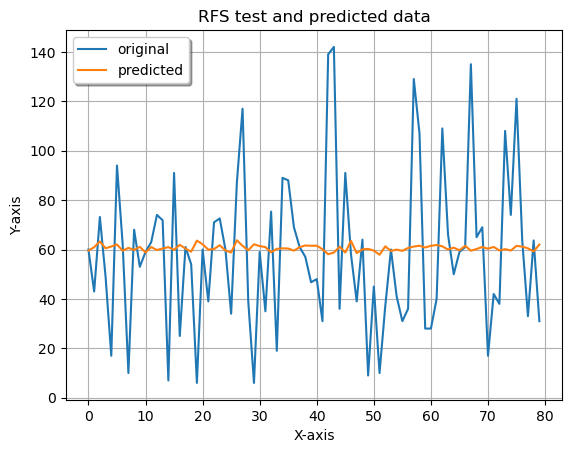

Annreg MAE score: 24.06855101585388
Annreg best estimator: <keras.engine.sequential.Sequential object at 0x7f9f61de4810>

--------------------------------------------------------
bestModel: GridSearchCV(cv=KFold(n_splits=10, random_state=8, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [1, 2, 3, 4, 5, 6],
                         'gamma': [0.1, 1.0, 10.0, 'scale', 'auto'],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=1)
bestParam: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
bestScore: 21.631399220404592


In [37]:
## PCA only ANN keras
import random

def plot_draw(y_best, y_pred):
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scores = []
best_estimator = []
best_params = {}
best_score = 100
k=1
for train, test in outer_cv.split(X_train):
    # training and validation
    X_outer_train = X_train[train]
    y_outer_train = y_train[train]
    X_outer_test = X_train[test]
    y_outer_test = y_train[test]

    activation = ['relu','tanh','sigmoid', 'exponential', 'softmax', 'softplus','softsign','selu','elu']
    ANNreg = Sequential()  
    # Defining the Input layer and FIRST hidden layer, both are same!
    ANNreg.add(Dense(random.randint(0,22), input_dim=22,kernel_initializer='normal', activation = activation[random.randint(0,8)]))
    #Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    ANNreg.add(Dense(random.randint(0,22), kernel_initializer='normal', activation=activation[random.randint(0,8)]))
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    ANNreg.add(Dense(random.randint(0,22), kernel_initializer='normal', activation=activation[random.randint(0,8)]))
    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    ANNreg.add(Dense(1, kernel_initializer='normal', activation=activation[random.randint(0,3)]))
    # Compile model
    ANNreg.compile(optimizer = 'adam', loss ='mean_absolute_error')
    ANNreg.save_weights('model.h5')

    #model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=2, verbose=3)
    #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=500, verbose=3)
    for inner_train_index, inner_validation_index in inner_cv.split(X_outer_train):
        X_inner_train, X_validation = X_outer_train[inner_train_index], X_outer_train[inner_validation_index]
        y_inner_train, y_validation = y_outer_train[inner_train_index], y_outer_train[inner_validation_index]
        ANNreg.load_weights('model.h5')
        model = ANNreg.fit(X_inner_train,
                        y_inner_train, 
                        epochs = 30, 
                        validation_data=(X_validation,y_validation))
        # evaluate the accuracy of each fold
        prediction = ANNreg.predict(X_outer_test)
        score = metrics.mean_absolute_error(y_outer_test, prediction) # use mse as metrics in K-fold, y_test), verbose=0)
        #scores.append(score)
        # scores = ann.evaluate(X_test,np.array(y_test), verbose=0)

        if best_score >= score:
            best_score = score
            # y_best = y_test
            # y_pred = prediction
            best_estimator = model
            ANNreg.save("ANN_model_Markov_dt_pca")
            #best_params = model.best_params_
    print("OuterLoop {} - Annreg MAE score: {}".format(k, best_score))
    k+=1

model = keras.models.load_model('ANN_model_Markov_dt_pca')
y_pred = model.predict(X_test)
score = metrics.mean_absolute_error(y_test, y_pred)
plot_draw(y_test, y_pred)

if score < bestScore:
    bestModel = model
    bestScore = score
    bestParam = 'ANN keras'

print("Annreg MAE score: {}".format(score))
print("Annreg best estimator: {}\n".format(model))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel))
print("bestParam: {}".format(bestParam))
print("bestScore: {}".format(bestScore))


Epoch 1/30
10/10 [==============================] - 0s 13ms/step - loss: 55.3345 - val_loss: 55.8918
Epoch 2/30
10/10 [==============================] - 0s 3ms/step - loss: 55.2956 - val_loss: 55.8527
Epoch 3/30
10/10 [==============================] - 0s 3ms/step - loss: 55.2564 - val_loss: 55.8133
Epoch 4/30
10/10 [==============================] - 0s 4ms/step - loss: 55.2168 - val_loss: 55.7735
Epoch 5/30
10/10 [==============================] - 0s 3ms/step - loss: 55.1767 - val_loss: 55.7330
Epoch 6/30
10/10 [==============================] - 0s 3ms/step - loss: 55.1358 - val_loss: 55.6915
Epoch 7/30
10/10 [==============================] - 0s 3ms/step - loss: 55.0935 - val_loss: 55.6490
Epoch 8/30
10/10 [==============================] - 0s 3ms/step - loss: 55.0501 - val_loss: 55.6055
Epoch 9/30
10/10 [==============================] - 0s 3ms/step - loss: 55.0064 - val_loss: 55.5632
Epoch 10/30
10/10 [==============================] - 0s 3ms/step - loss: 54.9653 - val_loss: 55.525

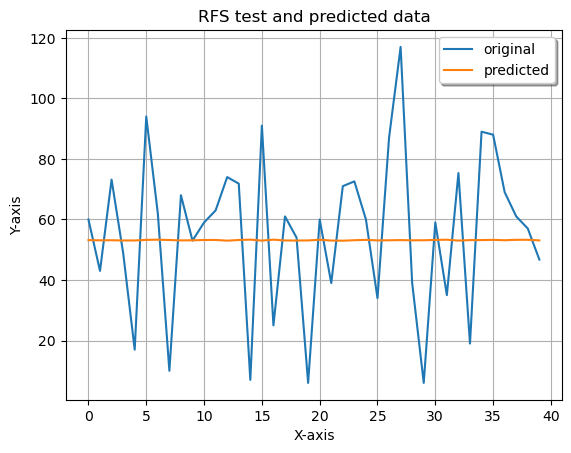

Annreg MAE score: 20.906880633036295
Annreg best estimator: <keras.engine.sequential.Sequential object at 0x7f9f8389c390>

--------------------------------------------------------
bestModel: <keras.engine.sequential.Sequential object at 0x7f9f8389c390>
bestParam: ANN keras
bestScore: 20.906880633036295


In [38]:
## PCA only ANN keras
import random

def plot_draw(y_best, y_pred):
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

scores = []
best_estimator = []
best_params = {}
best_score = 100
k=1
for train, test in outer_cv.split(X_train):
    # training and validation
    X_outer_train = X_train[train]
    y_outer_train = y_train[train]
    X_outer_test = X_train[test]
    y_outer_test = y_train[test]

    activation = ['relu','tanh','sigmoid', 'exponential', 'softmax', 'softplus','softsign','selu','elu']
    ANNreg = Sequential()  
    # Defining the Input layer and FIRST hidden layer, both are same!
    ANNreg.add(Dense(random.randint(0,22), input_dim=22,kernel_initializer='normal', activation = activation[random.randint(0,8)]))
    #Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    ANNreg.add(Dense(random.randint(0,22), kernel_initializer='normal', activation=activation[random.randint(0,8)]))
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    ANNreg.add(Dense(random.randint(0,22), kernel_initializer='normal', activation=activation[random.randint(0,8)]))
    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    ANNreg.add(Dense(1, kernel_initializer='normal', activation=activation[random.randint(0,3)]))
    # Compile model
    ANNreg.compile(optimizer = 'adam', loss ='mean_absolute_error')
    ANNreg.save_weights('model.h5')

    #model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=2, verbose=3)
    #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=500, verbose=3)
    for inner_train_index, inner_validation_index in inner_cv.split(X_outer_train):
        X_inner_train, X_validation = X_outer_train[inner_train_index], X_outer_train[inner_validation_index]
        y_inner_train, y_validation = y_outer_train[inner_train_index], y_outer_train[inner_validation_index]
        ANNreg.load_weights('model.h5')
        model = ANNreg.fit(X_inner_train,
                        y_inner_train, 
                        epochs = 30, 
                        validation_data=(X_validation,y_validation))
        # evaluate the accuracy of each fold
        prediction = ANNreg.predict(X_outer_test)
        score = metrics.mean_absolute_error(y_outer_test, prediction) # use mse as metrics in K-fold, y_test), verbose=0)
        #scores.append(score)
        # scores = ann.evaluate(X_test,np.array(y_test), verbose=0)

        if best_score >= score:
            best_score = score
            # y_best = y_test
            # y_pred = prediction
            best_estimator = model
            ANNreg.save("ANN_model_Markov_dt_pca")
            #best_params = model.best_params_
    print("OuterLoop {} - Annreg MAE score: {}".format(k, best_score))
    k+=1

model = keras.models.load_model('ANN_model_Markov_dt_pca')
y_pred = model.predict(X_test)
score = metrics.mean_absolute_error(y_test, y_pred)
plot_draw(y_test, y_pred)

if score < bestScore:
    bestModel = model
    bestScore = score
    bestParam = 'ANN keras'

print("Annreg MAE score: {}".format(score))
print("Annreg best estimator: {}\n".format(model))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel))
print("bestParam: {}".format(bestParam))
print("bestScore: {}".format(bestScore))


---
# Markov Blanket - Decision Tree

Data shape:  (400, 117) Target Variable shape:  (400,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s rema

Markov Blanket:  ['original_shape_VoxelVolume', 'original_shape_SurfaceArea', 'original_firstorder_Mean', 'original_firstorder_Maximum', 'original_firstorder_90Percentile', 'original_firstorder_InterquartileRange', 'original_shape_Maximum2DDiameterColumn', 'original_firstorder_Range', 'original_firstorder_MeanAbsoluteDeviation', 'original_glcm_DifferenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_shape_LeastAxisLength', 'original_firstorder_Kurtosis', 'original_firstorder_10Percentile', 'original_shape_Maximum2DDiameterRow', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_shape_MeshVolume', 'HistologyType', 'original_firstorder_Variance', 'original_glrlm_LongRunLowGrayLevelEmphasis']
Feature importance:  [5.832859516931343, 4.292414475984194, 3.9870328264330124, 3.8754238171114435, 3.766136486658114, 3.434964244132973, 3.434964244132973, 3.1702716899058907, 2.726779186208487, 2.1523483124879235, 2.1523483124879235, 1.9827119152212849, 1.6524397194192786, 1.533

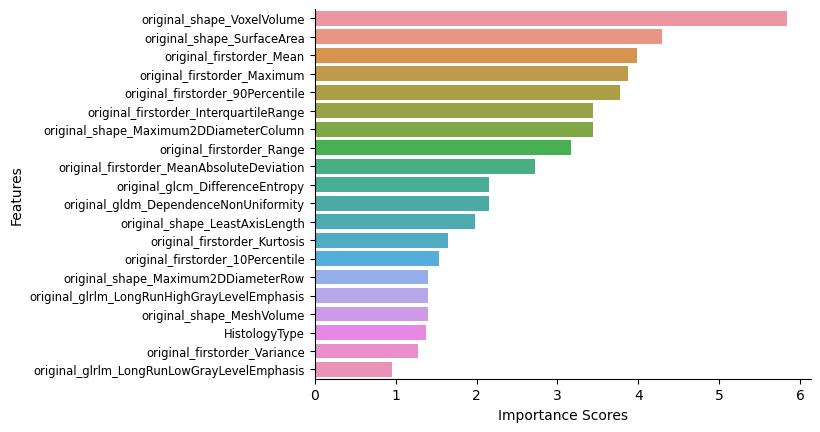

In [8]:
data1,Y1 = df_pca.drop(columns =['Y_reg','Y_clf']), df_pca['Y_reg'].values
print("Data shape: ", data1.shape, "Target Variable shape: ", Y1.shape)
# Use Train-test split for understanding the performance of PyImpetus
x_train, x_test, y_train, y_test = train_test_split(data1, Y1, test_size=0.2, random_state=27, shuffle=True)
# We want to time our algorithm
start = time.time()

# Create a PyImpetus regressor object and initialize with required parameters
model = PPIMBR(DecisionTreeRegressor(random_state=27), cv=0, p_val_thresh=0.4, num_simul=10, simul_size=0.2, sig_test_type="non-parametric", random_state=27, verbose=2, n_jobs=None)
# Fit this above object on the train part and transform the train dataset into selected feature subset
# NOTE: x_train has to be a dataframe and y_train has to be a numpy array
model.fit(x_train, y_train)
x_train = model.transform(x_train)
# Transform the test set as well
# NOTE: x_test has to be a dataframe
x_test = model.transform(x_test)
# Check out the number of features selected
print("Markov Blanket: ", model.MB)
markov_cols_dt = model.MB
print("Feature importance: ", model.feat_imp_scores)
print("Number of features selected: ", len(model.MB))
model.feature_importance()
# Convert the data into numpy arrays
x_train, x_test = x_train.values, x_test.values


# model = DecisionTreeRegressor(random_state=27)
# model.fit(x_train, y_train)
# preds = model.predict(x_test)
# score = metrics.mean_squared_error(y_test, preds)
# print("Score: ", score)
# end = time.time()
# print("Time Required (in seconds): ", end-start)


In [9]:
#split X and y
print(len(markov_cols_dt), markov_cols_dt)
X = df_pca[markov_cols_dt].values
y = df_pca['Y_reg'].values

20 ['original_shape_VoxelVolume', 'original_shape_SurfaceArea', 'original_firstorder_Mean', 'original_firstorder_Maximum', 'original_firstorder_90Percentile', 'original_firstorder_InterquartileRange', 'original_shape_Maximum2DDiameterColumn', 'original_firstorder_Range', 'original_firstorder_MeanAbsoluteDeviation', 'original_glcm_DifferenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_shape_LeastAxisLength', 'original_firstorder_Kurtosis', 'original_firstorder_10Percentile', 'original_shape_Maximum2DDiameterRow', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_shape_MeshVolume', 'HistologyType', 'original_firstorder_Variance', 'original_glrlm_LongRunLowGrayLevelEmphasis']


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits


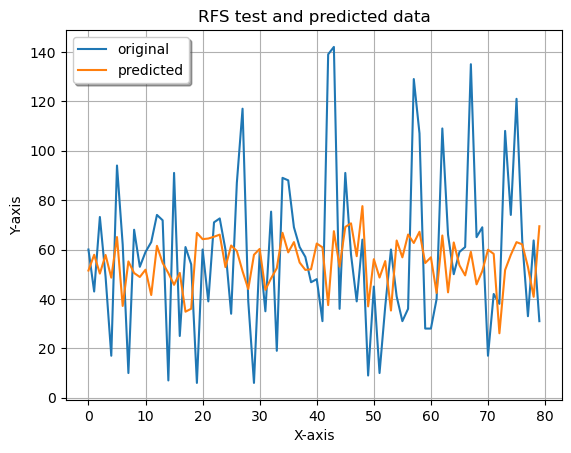

Lreg best param: {'fit_intercept': False}
Lreg MAE score: 25.210275392875584

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits


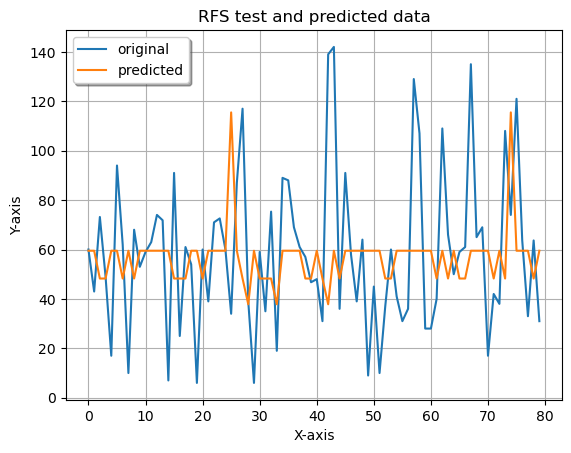

DTreg best param: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3}
DTreg MAE score: 25.57932474951124

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits


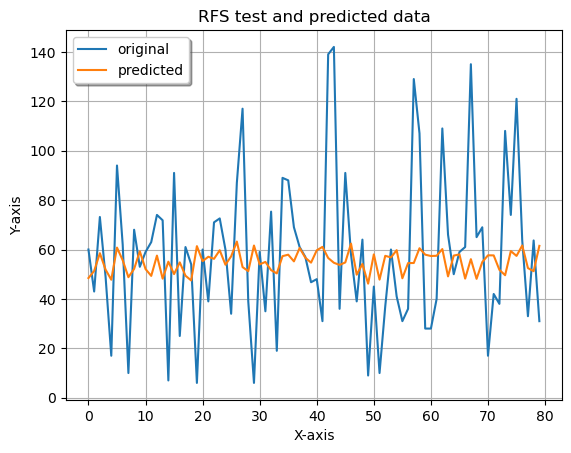

SVMreg best param: {'C': 3, 'gamma': 1.0, 'kernel': 'rbf'}
SVMreg MAE score: 24.299011682207265

--------------------------------------------------------
bestModel: GridSearchCV(cv=KFold(n_splits=10, random_state=8, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [1, 2, 3, 4, 5, 6],
                         'gamma': [0.1, 1.0, 10.0, 'scale', 'auto'],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=1)
bestParam: {'C': 3, 'gamma': 1.0, 'kernel': 'rbf'}
bestScore: 24.299011682207265


In [10]:
""" Markov Blanket DT nested cross validation """

def cross_val(estimator, X_train, y_train, parameters, inner_cv, outer_cv):
    best_model = None
    best_params = None
    best_score = 100
    for train, test in outer_cv.split(X_train):
        # training and validation
        X_outer_train = X_train[train]
        y_outer_train = y_train[train]
        X_outer_test = X_train[test]
        y_outer_test = y_train[test]

        model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=None, verbose=1)
        #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=5, verbose=3)
        model.fit(X_outer_train, y_outer_train)
        # evaluate the accuracy of each fold
        prediction = model.predict(X_outer_test)
        score = metrics.mean_absolute_error(y_outer_test, prediction) # use mse as metrics in K-fold, np.array(y_test), verbose=0)

        if best_score > score:
            best_score = score
            best_model = model
            best_params = model.best_params_
    return best_score, best_model, best_params

def plot_draw(y_best, y_pred):
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)    
bestModel = None
bestParam = None
bestScore = 100

################################################################################

#hyper parameter tuning for LinearRegression
lreg_parameters = {"fit_intercept":[True,False]}

## call model
Lreg = linear_model.LinearRegression()

train_score, estimator, param = cross_val(Lreg, X_train, y_train, lreg_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "Lreg_pca_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore:
    bestModel = estimator
    bestScore = score
    bestParam = param

# print("Lreg trained MAE best score: {}".format(train_score))
print("Lreg best param: {}".format(param))
# print("Lreg best estimator: {}".format(estimator))
print("Lreg MAE score: {}\n".format(score))


################################################################################

#hyper parameter tuning for Decision Tree
dt_parameters = {"max_depth" : [3,9,12],
           "min_samples_leaf":[3,6,9],
           "max_features":["auto","log2","sqrt",None]}

## call model
DTreg = DecisionTreeRegressor()

train_score, estimator, param = cross_val(DTreg, X_train, y_train, dt_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "DTreg_nested_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore:
    bestModel = estimator
    bestScore = score
    bestParam = param

# print("DTreg trained MAE best score: {}".format(train_score))
print("DTreg best param: {}".format(param))
# print("DTreg best estimator: {}".format(estimator))
print("DTreg MAE score: {}\n".format(score))

################################################################################

#hyper parameter tuning for SVM
svm_parameters = {"kernel":['rbf', 'sigmoid'],
           "gamma":[0.1,1.0,10.0,'scale','auto'],
           "C": [1,2,3,4,5,6]}

## call model
SVMreg = svm.SVR()

train_score, estimator, param = cross_val(SVMreg, X_train, y_train, svm_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "SVMreg_nested_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore:
    bestModel = estimator
    bestScore = score
    bestParam = param

# print("SVMreg trained MAE best score: {}".format(train_score))
print("SVMreg best param: {}".format(param))
# print("SVMreg best estimator: {}".format(estimator))
print("SVMreg MAE score: {}\n".format(score))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel))
print("bestParam: {}".format(bestParam))
print("bestScore: {}".format(bestScore))

Epoch 1/30
9/9 [==============================] - 1s 32ms/step - loss: 55.3757 - val_loss: 61.4166
Epoch 2/30
9/9 [==============================] - 0s 3ms/step - loss: 55.3479 - val_loss: 61.3890
Epoch 3/30
9/9 [==============================] - 0s 3ms/step - loss: 55.3204 - val_loss: 61.3617
Epoch 4/30
9/9 [==============================] - 0s 3ms/step - loss: 55.2931 - val_loss: 61.3345
Epoch 5/30
9/9 [==============================] - 0s 3ms/step - loss: 55.2660 - val_loss: 61.3073
Epoch 6/30
9/9 [==============================] - 0s 3ms/step - loss: 55.2388 - val_loss: 61.2801
Epoch 7/30
9/9 [==============================] - 0s 3ms/step - loss: 55.2116 - val_loss: 61.2529
Epoch 8/30
9/9 [==============================] - 0s 3ms/step - loss: 55.1843 - val_loss: 61.2256
Epoch 9/30
9/9 [==============================] - 0s 3ms/step - loss: 55.1572 - val_loss: 61.1986
Epoch 10/30
9/9 [==============================] - 0s 6ms/step - loss: 55.1304 - val_loss: 61.1724
Epoch 11/30
9/9 [=

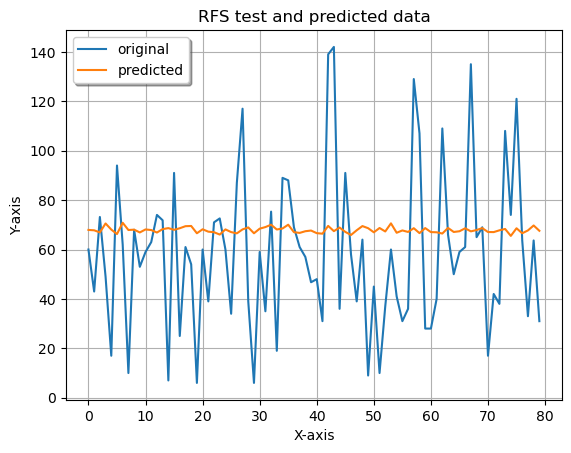

Annreg MAE score: 26.187850062052405
Annreg best estimator: <keras.engine.sequential.Sequential object at 0x7f9f448db3d0>

--------------------------------------------------------
bestModel: GridSearchCV(cv=KFold(n_splits=10, random_state=8, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [1, 2, 3, 4, 5, 6],
                         'gamma': [0.1, 1.0, 10.0, 'scale', 'auto'],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=1)
bestParam: {'C': 3, 'gamma': 1.0, 'kernel': 'rbf'}
bestScore: 24.299011682207265


In [12]:
## Markov Blanket ANN keras
import random

def plot_draw(y_best, y_pred):
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scores = []
best_estimator = []
best_params = {}
best_score = 100
k=1
for train, test in outer_cv.split(X_train):
    # training and validation
    X_outer_train = X_train[train]
    y_outer_train = y_train[train]
    X_outer_test = X_train[test]
    y_outer_test = y_train[test]

    activation = ['relu','tanh','sigmoid', 'exponential', 'softmax', 'softplus','softsign','selu','elu']
    ANNreg = Sequential()  
    # Defining the Input layer and FIRST hidden layer, both are same!
    ANNreg.add(Dense(random.randint(0,20), input_dim=20,kernel_initializer='normal', activation = activation[random.randint(0,8)]))
    #Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    ANNreg.add(Dense(random.randint(0,20), kernel_initializer='normal', activation=activation[random.randint(0,8)]))
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    ANNreg.add(Dense(random.randint(0,20), kernel_initializer='normal', activation=activation[random.randint(0,8)]))
    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    ANNreg.add(Dense(1, kernel_initializer='normal', activation=activation[random.randint(0,3)]))
    # Compile model
    ANNreg.compile(optimizer = 'adam', loss ='mean_absolute_error')
    ANNreg.save_weights('model.h5')

    #model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=2, verbose=3)
    #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=500, verbose=3)
    for inner_train_index, inner_validation_index in inner_cv.split(X_outer_train):
        X_inner_train, X_validation = X_outer_train[inner_train_index], X_outer_train[inner_validation_index]
        y_inner_train, y_validation = y_outer_train[inner_train_index], y_outer_train[inner_validation_index]
        ANNreg.load_weights('model.h5')
        model = ANNreg.fit(X_inner_train,
                        y_inner_train, 
                        epochs = 30, 
                        validation_data=(X_validation,y_validation))
        # evaluate the accuracy of each fold
        prediction = ANNreg.predict(X_outer_test)
        score = metrics.mean_absolute_error(y_outer_test, prediction) # use mse as metrics in K-fold, y_test), verbose=0)
        #scores.append(score)
        # scores = ann.evaluate(X_test,np.array(y_test), verbose=0)

        if best_score >= score:
            best_score = score
            # y_best = y_test
            # y_pred = prediction
            best_estimator = model
            ANNreg.save("ANN_model_Markov_dt_pca")
            #best_params = model.best_params_
    print("OuterLoop {} - Annreg MAE score: {}".format(k, best_score))
    k+=1

model = keras.models.load_model('ANN_model_Markov_dt_pca')
y_pred = model.predict(X_test)
score = metrics.mean_absolute_error(y_test, y_pred)
plot_draw(y_test, y_pred)

if score < bestScore:
    bestModel = model
    bestScore = score
    bestParam = 'ANN keras'

print("Annreg MAE score: {}".format(score))
print("Annreg best estimator: {}\n".format(model))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel))
print("bestParam: {}".format(bestParam))
print("bestScore: {}".format(bestScore))


In [13]:
## Markov Blanket ANN sklearn
np.warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import random

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

best_score = 100
best_model = None
outerLoop = KFold(n_splits=10)
innerLoop = KFold(n_splits=10)

outerK = 0

for outter_train_index, outter_test_index in outerLoop.split(X_train):

    #print("outer K: ",(outerK+1))
    outerK += 1
    X_total_train, X_total_test = X_train[outter_train_index], X_train[outter_test_index]
    y_total_train, y_total_test = y_train[outter_train_index], y_train[outter_test_index]

    param_mlpr = {   
                    'hidden_layer_sizes' : [(7,5,3),(5),(7,5)],
                    'activation' : ['identity','logistic','tanh','relu'],
                    "random_state" : range(0, 50),
                    'batch_size' : [5,10],
                    'alpha' : [0.0001, 0.001, 0.01],
                    'solver' : ['sgd','adam', 'lbfgs'],
                    'learning_rate' : ['constant','invscaling'],
                    }
    #find the best parameter tunning
    #to be implemented

    grid = RandomizedSearchCV(MLPRegressor(max_iter= 2000),param_mlpr,cv=innerLoop,refit=True,verbose=1,n_iter= 3)
    model = grid.fit(X_total_train, y_total_train)

    #fit the model using the best parameter
    y_pred = model.predict(X_total_test)
    score = metrics.mean_absolute_error(y_total_test, y_pred)

    #keep a reference of the best model for further usage
    if(score < best_score):
        best_score = score
        best_model = model

y_pred = best_model.predict(X_test)
score = metrics.mean_absolute_error(y_test, y_pred)
# joblib.dump(bestModel, "ANNreg_nested_markov_dt.pkl")

if score < bestScore:
    bestModel = best_model
    bestScore = score
    bestParam = best_model.best_params_

print("Best Model MAE: {}".format(score))
print("Best Model Parameters: {}".format(best_model.best_params_))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel))
print("bestParam: {}".format(bestParam))
print("bestScore: {}".format(bestScore))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Model MAE: 23.93760931128178
Best Model Parameters: {'solver': 'sgd', 'random_state': 11, 'learning_rate': 'constant', 'hidden_layer_sizes': 5, 'batch_size': 5, 'alpha': 0.0001, 'activation': 'logistic'}
--------------------------------------------------------
bestModel: RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=MLPRegre

In [14]:
#joblib.dump(bestModel,'markov_dt_PCA.pkl')
print("bestModel: {}".format(bestModel))
print("bestParam: {}".format(bestParam))
print("bestScore: {}".format(bestScore))

bestModel: RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=MLPRegressor(max_iter=2000), n_iter=3,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'batch_size': [5, 10],
                                        'hidden_layer_sizes': [(7, 5, 3), 5,
                                                               (7, 5)],
                                        'learning_rate': ['constant',
                                                          'invscaling'],
                                        'random_state': range(0, 50),
                                        'solver': ['sgd', 'adam', 'lbfgs']},
                   verbose=1)
bestParam: {'solver': 'sgd', 'random_state': 11, 'learning_rate': 'constant', 'hidden_laye

---
# Markov Blanket - SVR

Data shape:  (400, 117) Target Variable shape:  (400,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s rema

Markov Blanket:  ['original_firstorder_90Percentile', 'original_firstorder_RootMeanSquared', 'original_shape_Sphericity', 'original_firstorder_Range', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_InterquartileRange', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_shape_Maximum2DDiameterColumn', 'HistologyType', 'TumourStage', 'original_firstorder_Maximum', 'original_glszm_ZoneEntropy', 'original_firstorder_Energy', 'original_firstorder_TotalEnergy', 'original_firstorder_Median', 'original_shape_MinorAxisLength', 'original_shape_Maximum2DDiameterSlice', 'original_firstorder_Mean', 'original_firstorder_Variance', 'original_shape_MajorAxisLength', 'original_shape_SurfaceArea', 'original_firstorder_Skewness', 'original_shape_Flatness', 'ER', 'original_shape_Maximum3DDiameter', 'original_glrlm_GrayLevelNonUniformity', 'original_glszm_ZoneVariance', 'original_shape_Maximum2DDiameterRow', 'original_shape_LeastAxisLength', 'original_glszm_SmallAreaHighGrayLev

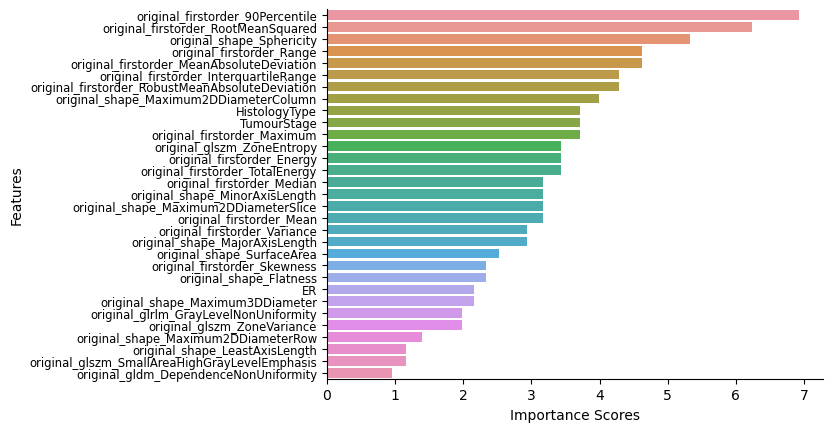

In [15]:
data1,Y1 = df_pca.drop(columns =['Y_reg','Y_clf']), df_pca['Y_reg'].values
print("Data shape: ", data1.shape, "Target Variable shape: ", Y1.shape)
# Use Train-test split for understanding the performance of PyImpetus
x_train, x_test, y_train, y_test = train_test_split(data1, Y1, test_size=0.2, random_state=27, shuffle=True)
# We want to time our algorithm
start = time.time()

# Create a PyImpetus regressor object and initialize with required parameters
model = PPIMBR(svm.SVR(), cv=0, p_val_thresh=0.4, num_simul=10, simul_size=0.2, sig_test_type="non-parametric", random_state=27, verbose=2, n_jobs=None)
# Fit this above object on the train part and transform the train dataset into selected feature subset
# NOTE: x_train has to be a dataframe and y_train has to be a numpy array
model.fit(x_train, y_train)
x_train = model.transform(x_train)
# Transform the test set as well
# NOTE: x_test has to be a dataframe
x_test = model.transform(x_test)
# Check out the number of features selected
print("Markov Blanket: ", model.MB)
markov_svr_cols = model.MB
print("Feature importance: ", model.feat_imp_scores)
print("Number of features selected: ", len(model.MB))
model.feature_importance()
# Convert the data into numpy arrays
x_train, x_test = x_train.values, x_test.values


# model = DecisionTreeRegressor(random_state=27)
# model.fit(x_train, y_train)
# preds = model.predict(x_test)
# score = metrics.mean_squared_error(y_test, preds)
# print("Score: ", score)
# end = time.time()
# print("Time Required (in seconds): ", end-start)


In [16]:
# cols = ['original_shape_VoxelVolume', 'original_shape_SurfaceArea', 'original_firstorder_Mean', 
# 'original_firstorder_Maximum', 'original_firstorder_90Percentile', 'original_firstorder_InterquartileRange', 
# 'original_shape_Maximum2DDiameterColumn', 'original_firstorder_Range', 'original_firstorder_MeanAbsoluteDeviation', 
# 'original_glcm_DifferenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_shape_LeastAxisLength', 'original_firstorder_Kurtosis', 
# 'original_firstorder_10Percentile', 'original_shape_Maximum2DDiameterRow', 'original_glrlm_LongRunHighGrayLevelEmphasis', 
# 'original_shape_MeshVolume', 'HistologyType', 'original_firstorder_Variance', 'original_glrlm_LongRunLowGrayLevelEmphasis']

print(len(markov_svr_cols), markov_svr_cols)
X = df_pca[markov_svr_cols].values
#X = df_pca.drop(['Y_reg', 'Y_clf'], axis=1).values
y = df_pca['Y_reg'].values

31 ['original_firstorder_90Percentile', 'original_firstorder_RootMeanSquared', 'original_shape_Sphericity', 'original_firstorder_Range', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_InterquartileRange', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_shape_Maximum2DDiameterColumn', 'HistologyType', 'TumourStage', 'original_firstorder_Maximum', 'original_glszm_ZoneEntropy', 'original_firstorder_Energy', 'original_firstorder_TotalEnergy', 'original_firstorder_Median', 'original_shape_MinorAxisLength', 'original_shape_Maximum2DDiameterSlice', 'original_firstorder_Mean', 'original_firstorder_Variance', 'original_shape_MajorAxisLength', 'original_shape_SurfaceArea', 'original_firstorder_Skewness', 'original_shape_Flatness', 'ER', 'original_shape_Maximum3DDiameter', 'original_glrlm_GrayLevelNonUniformity', 'original_glszm_ZoneVariance', 'original_shape_Maximum2DDiameterRow', 'original_shape_LeastAxisLength', 'original_glszm_SmallAreaHighGrayLevelEmphasis', '

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits


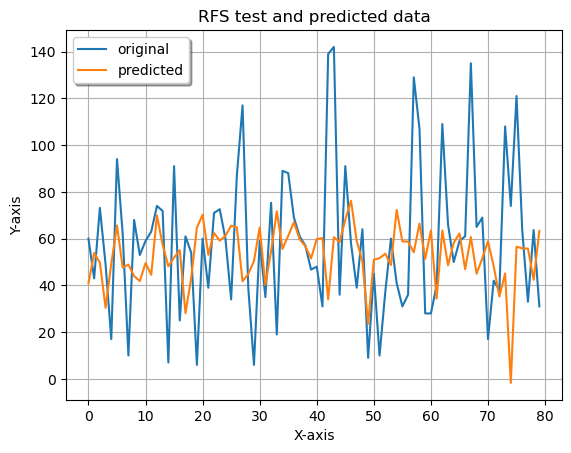

Lreg best param: {'fit_intercept': False}
Lreg MAE score: 25.933085663076515

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits


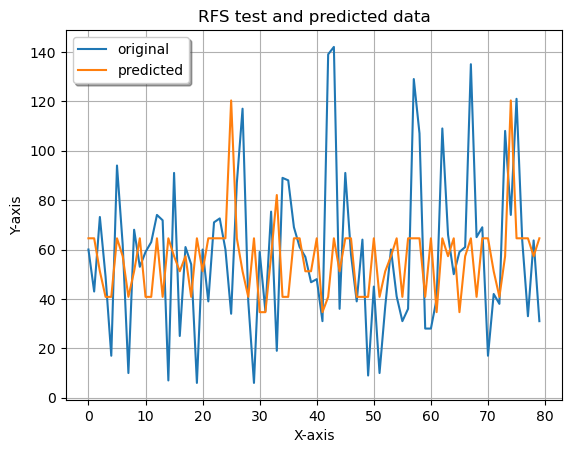

DTreg best param: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3}
DTreg MAE score: 25.3335293161258

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits


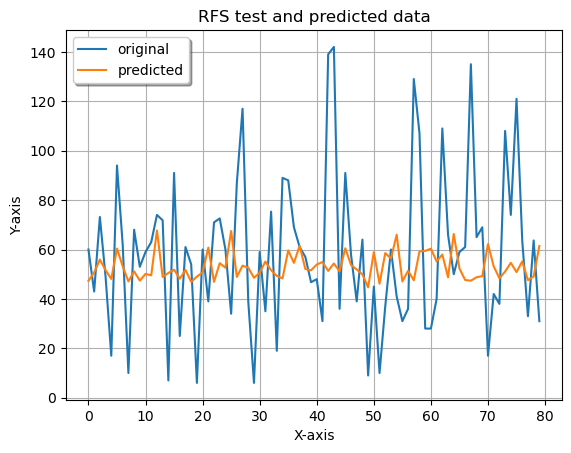

SVMreg best param: {'C': 4, 'gamma': 1.0, 'kernel': 'rbf'}
SVMreg MAE score: 25.06651559505833

--------------------------------------------------------
bestModel: GridSearchCV(cv=KFold(n_splits=10, random_state=8, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [1, 2, 3, 4, 5, 6],
                         'gamma': [0.1, 1.0, 10.0, 'scale', 'auto'],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=1)
bestParam: {'C': 4, 'gamma': 1.0, 'kernel': 'rbf'}
bestScore: 25.06651559505833


In [17]:
""" Markov Blanket SVR nested cross validation """

def cross_val(estimator, X_train, y_train, parameters, inner_cv, outer_cv):
    best_model = None
    best_params = None
    best_score = 100
    for train, test in outer_cv.split(X_train):
        # training and validation
        X_outer_train = X_train[train]
        y_outer_train = y_train[train]
        X_outer_test = X_train[test]
        y_outer_test = y_train[test]

        model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=None, verbose=1)
        #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=5, verbose=3)
        model.fit(X_outer_train, y_outer_train)
        # evaluate the accuracy of each fold
        prediction = model.predict(X_outer_test)
        score = metrics.mean_absolute_error(y_outer_test, prediction) # use mse as metrics in K-fold, np.array(y_test), verbose=0)

        if best_score > score:
            best_score = score
            best_model = model
            best_params = model.best_params_
    return best_score, best_model, best_params

def plot_draw(y_best, y_pred):
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)    
bestModel_markov_svr = None
bestParam_markov_svr = None
bestScore_markov_svr = 100

################################################################################

#hyper parameter tuning for LinearRegression
lreg_parameters = {"fit_intercept":[True,False]}

## call model
Lreg = linear_model.LinearRegression()

train_score, estimator, param = cross_val(Lreg, X_train, y_train, lreg_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "Lreg_pca_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore_markov_svr:
    bestModel_markov_svr = estimator
    bestScore_markov_svr = score
    bestParam_markov_svr = param

# print("Lreg trained MAE best score: {}".format(train_score))
print("Lreg best param: {}".format(param))
# print("Lreg best estimator: {}".format(estimator))
print("Lreg MAE score: {}\n".format(score))


################################################################################

#hyper parameter tuning for Decision Tree
dt_parameters = {"max_depth" : [3,9,12],
           "min_samples_leaf":[3,6,9],
           "max_features":["auto","log2","sqrt",None]}

## call model
DTreg = DecisionTreeRegressor()

train_score, estimator, param = cross_val(DTreg, X_train, y_train, dt_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "DTreg_nested_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore_markov_svr:
    bestModel_markov_svr = estimator
    bestScore_markov_svr = score
    bestParam_markov_svr = param

# print("DTreg trained MAE best score: {}".format(train_score))
print("DTreg best param: {}".format(param))
# print("DTreg best estimator: {}".format(estimator))
print("DTreg MAE score: {}\n".format(score))

################################################################################

#hyper parameter tuning for SVM
svm_parameters = {"kernel":['rbf', 'sigmoid'],
           "gamma":[0.1,1.0,10.0,'scale','auto'],
           "C": [1,2,3,4,5,6]}

## call model
SVMreg = svm.SVR()

train_score, estimator, param = cross_val(SVMreg, X_train, y_train, svm_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "SVMreg_nested_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore_markov_svr:
    bestModel_markov_svr = estimator
    bestScore_markov_svr = score
    bestParam_markov_svr = param

# print("SVMreg trained MAE best score: {}".format(train_score))
print("SVMreg best param: {}".format(param))
# print("SVMreg best estimator: {}".format(estimator))
print("SVMreg MAE score: {}\n".format(score))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel_markov_svr))
print("bestParam: {}".format(bestParam_markov_svr))
print("bestScore: {}".format(bestScore_markov_svr))

In [18]:
## Markov Blanket ANN sklearn
np.warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import random

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

best_score = 100
best_model = None
outerLoop = KFold(n_splits=10)
innerLoop = KFold(n_splits=10)

outerK = 0

for outter_train_index, outter_test_index in outerLoop.split(X_train):

    #print("outer K: ",(outerK+1))
    outerK += 1
    X_total_train, X_total_test = X_train[outter_train_index], X_train[outter_test_index]
    y_total_train, y_total_test = y_train[outter_train_index], y_train[outter_test_index]

    param_mlpr = {   
                    'hidden_layer_sizes' : [(7,5,3),(5),(7,5)],
                    'activation' : ['identity','logistic','tanh','relu'],
                    "random_state" : range(0, 50),
                    'batch_size' : [5,10],
                    'alpha' : [0.0001, 0.001, 0.01],
                    'solver' : ['sgd','adam', 'lbfgs'],
                    'learning_rate' : ['constant','invscaling'],
                    }
    #find the best parameter tunning
    #to be implemented

    grid = RandomizedSearchCV(MLPRegressor(max_iter= 2000),param_mlpr,cv=innerLoop,refit=True,verbose=1,n_iter= 3)
    model = grid.fit(X_total_train, y_total_train)

    #fit the model using the best parameter
    y_pred = model.predict(X_total_test)
    score = metrics.mean_absolute_error(y_total_test, y_pred)

    #keep a reference of the best model for further usage
    if(score < best_score):
        best_score = score
        best_model = model

y_pred = best_model.predict(X_test)
score = metrics.mean_absolute_error(y_test, y_pred)
# joblib.dump(bestModel, "ANNreg_nested_markov_dt.pkl")

if score < bestScore_markov_svr:
    bestModel_markov_svr = best_model
    bestScore_markov_svr = score
    bestParam_markov_svr = best_model.best_params_

print("Best Model MAE: {}".format(score))
print("Best Model Parameters: {}".format(best_model.best_params_))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel_markov_svr))
print("bestParam: {}".format(bestParam_markov_svr))
print("bestScore: {}".format(bestScore_markov_svr))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Model MAE: 24.10308959693585
Best Model Parameters: {'solver': 'sgd', 'random_state': 11, 'learning_rate': 'constant', 'hidden_layer_sizes': 5, 'batch_size': 5, 'alpha': 0.0001, 'activation': 'logistic'}
--------------------------------------------------------
bestModel: RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=MLPRegre

Epoch 1/30
9/9 [==============================] - 1s 32ms/step - loss: 55.8935 - val_loss: 61.8939
Epoch 2/30
9/9 [==============================] - 0s 7ms/step - loss: 55.7994 - val_loss: 61.7960
Epoch 3/30
9/9 [==============================] - 0s 5ms/step - loss: 55.6892 - val_loss: 61.6602
Epoch 4/30
9/9 [==============================] - 0s 7ms/step - loss: 55.5301 - val_loss: 61.4579
Epoch 5/30
9/9 [==============================] - 0s 6ms/step - loss: 55.2902 - val_loss: 61.1482
Epoch 6/30
9/9 [==============================] - 0s 5ms/step - loss: 54.9202 - val_loss: 60.6625
Epoch 7/30
9/9 [==============================] - 0s 5ms/step - loss: 54.3361 - val_loss: 59.8856
Epoch 8/30
9/9 [==============================] - 0s 7ms/step - loss: 53.3913 - val_loss: 58.6203
Epoch 9/30
9/9 [==============================] - 0s 4ms/step - loss: 51.8535 - val_loss: 56.5404
Epoch 10/30
9/9 [==============================] - 0s 4ms/step - loss: 49.3438 - val_loss: 53.0979
Epoch 11/30
9/9 [=

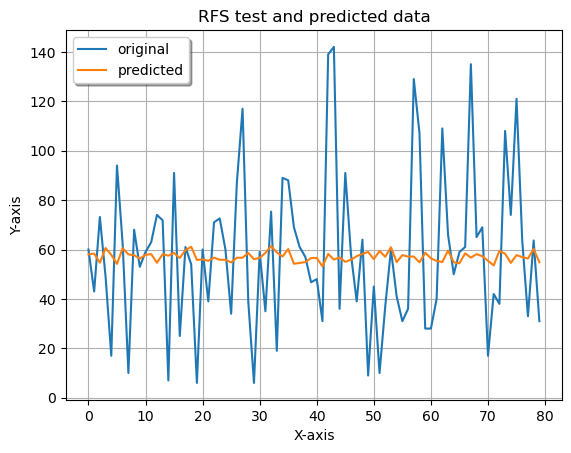

Annreg MAE score: 23.939497900009155
Annreg best estimator: <keras.engine.sequential.Sequential object at 0x7f9f45704610>

--------------------------------------------------------
bestModel: <keras.engine.sequential.Sequential object at 0x7f9f45704610>
bestParam: ANN keras
bestScore: 23.939497900009155


In [19]:
## Markov Blanket ANN keras
import random

def plot_draw(y_best, y_pred):
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scores = []
best_estimator = []
best_params = {}
best_score = 100
k=1
for train, test in outer_cv.split(X_train):
    # training and validation
    X_outer_train = X_train[train]
    y_outer_train = y_train[train]
    X_outer_test = X_train[test]
    y_outer_test = y_train[test]

    activation = ['relu','tanh','sigmoid', 'exponential', 'softmax', 'softplus','softsign','selu','elu']
    ANNreg = Sequential()  
    # Defining the Input layer and FIRST hidden layer, both are same!
    ANNreg.add(Dense(random.randint(0,31), input_dim=31,kernel_initializer='normal', activation = activation[random.randint(0,8)]))
    #Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    ANNreg.add(Dense(random.randint(0,31), kernel_initializer='normal', activation=activation[random.randint(0,8)]))
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    ANNreg.add(Dense(random.randint(0,31), kernel_initializer='normal', activation=activation[random.randint(0,8)]))
    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    ANNreg.add(Dense(1, kernel_initializer='normal', activation=activation[random.randint(0,3)]))
    # Compile model
    ANNreg.compile(optimizer = 'adam', loss ='mean_absolute_error')
    ANNreg.save_weights('model.h5')

    #model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=2, verbose=3)
    #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=500, verbose=3)
    for inner_train_index, inner_validation_index in inner_cv.split(X_outer_train):
        X_inner_train, X_validation = X_outer_train[inner_train_index], X_outer_train[inner_validation_index]
        y_inner_train, y_validation = y_outer_train[inner_train_index], y_outer_train[inner_validation_index]
        ANNreg.load_weights('model.h5')
        model = ANNreg.fit(X_inner_train,
                        y_inner_train, 
                        epochs = 30, 
                        validation_data=(X_validation,y_validation))
        # evaluate the accuracy of each fold
        prediction = ANNreg.predict(X_outer_test)
        score = metrics.mean_absolute_error(y_outer_test, prediction) # use mse as metrics in K-fold, y_test), verbose=0)
        #scores.append(score)
        # scores = ann.evaluate(X_test,np.array(y_test), verbose=0)

        if best_score >= score:
            best_score = score
            # y_best = y_test
            # y_pred = prediction
            best_estimator = model
            ANNreg.save("ANN_model_Markov_svr_2_8")
            #best_params = model.best_params_
    print("OuterLoop {} - Annreg MAE score: {}".format(k, best_score))
    k+=1

model = keras.models.load_model('ANN_model_Markov_svr_2_8')
y_pred = model.predict(X_test)
score = metrics.mean_absolute_error(y_test, y_pred)
plot_draw(y_test, y_pred)

if score < bestScore_markov_svr:
    bestModel_markov_svr = model
    bestScore_markov_svr = score
    bestParam_markov_svr = 'ANN keras'

print("Annreg MAE score: {}".format(score))
print("Annreg best estimator: {}\n".format(model))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel_markov_svr))
print("bestParam: {}".format(bestParam_markov_svr))
print("bestScore: {}".format(bestScore_markov_svr))


In [20]:
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel_markov_svr))
print("bestParam: {}".format(bestParam_markov_svr))
print("bestScore: {}".format(bestScore_markov_svr))

--------------------------------------------------------
bestModel: <keras.engine.sequential.Sequential object at 0x7f9f45704610>
bestParam: ANN keras
bestScore: 23.939497900009155


---
# Markov Blanket - GradientBoosting

Data shape:  (400, 117) Target Variable shape:  (400,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s rema

Markov Blanket:  ['original_shape_Maximum2DDiameterColumn', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_firstorder_Maximum', 'original_firstorder_InterquartileRange', 'HistologyType', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_shape_Maximum2DDiameterRow', 'original_shape_LeastAxisLength', 'original_firstorder_Median', 'original_shape_SurfaceArea', 'original_glrlm_RunVariance', 'original_gldm_DependenceNonUniformity', 'original_glrlm_RunEntropy', 'ER', 'original_firstorder_RobustMeanAbsoluteDeviation', 'TumourStage', 'original_firstorder_90Percentile', 'original_firstorder_Range', 'original_shape_SurfaceVolumeRatio']
Feature importance:  [6.238324625039508, 5.322033893165353, 3.9870328264330124, 3.434964244132973, 2.9424877590351786, 2.726779186208487, 2.726779186208487, 2.5247525583352, 2.411337789357106, 2.1523483124879235, 2.1523483124879235, 2.1523483124879235, 1.8255263316988726, 1.5730503743549573, 1.5333091040817004, 1.4020427180880297, 1.05654107474

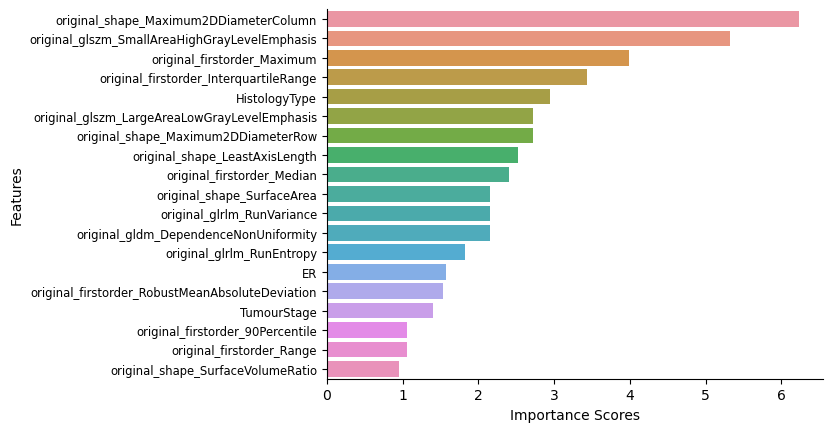

In [39]:
data1,Y1 = df_pca.drop(columns =['Y_reg','Y_clf']), df_pca['Y_reg'].values
print("Data shape: ", data1.shape, "Target Variable shape: ", Y1.shape)
# Use Train-test split for understanding the performance of PyImpetus
x_train, x_test, y_train, y_test = train_test_split(data1, Y1, test_size=0.2, random_state=27, shuffle=True)
# We want to time our algorithm
start = time.time()

# Create a PyImpetus regressor object and initialize with required parameters
model = PPIMBR(ensemble.GradientBoostingRegressor(), cv=0, p_val_thresh=0.4, num_simul=10, simul_size=0.2, sig_test_type="non-parametric", random_state=27, verbose=2, n_jobs=None)
# Fit this above object on the train part and transform the train dataset into selected feature subset
# NOTE: x_train has to be a dataframe and y_train has to be a numpy array
model.fit(x_train, y_train)
x_train = model.transform(x_train)
# Transform the test set as well
# NOTE: x_test has to be a dataframe
x_test = model.transform(x_test)
# Check out the number of features selected
print("Markov Blanket: ", model.MB)
markov_gbr_cols = model.MB
print("Feature importance: ", model.feat_imp_scores)
print("Number of features selected: ", len(model.MB))
model.feature_importance()
# Convert the data into numpy arrays
x_train, x_test = x_train.values, x_test.values


# model = DecisionTreeRegressor(random_state=27)
# model.fit(x_train, y_train)
# preds = model.predict(x_test)
# score = metrics.mean_squared_error(y_test, preds)
# print("Score: ", score)
# end = time.time()
# print("Time Required (in seconds): ", end-start)


In [40]:
# cols = ['original_shape_VoxelVolume', 'original_shape_SurfaceArea', 'original_firstorder_Mean', 
# 'original_firstorder_Maximum', 'original_firstorder_90Percentile', 'original_firstorder_InterquartileRange', 
# 'original_shape_Maximum2DDiameterColumn', 'original_firstorder_Range', 'original_firstorder_MeanAbsoluteDeviation', 
# 'original_glcm_DifferenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_shape_LeastAxisLength', 'original_firstorder_Kurtosis', 
# 'original_firstorder_10Percentile', 'original_shape_Maximum2DDiameterRow', 'original_glrlm_LongRunHighGrayLevelEmphasis', 
# 'original_shape_MeshVolume', 'HistologyType', 'original_firstorder_Variance', 'original_glrlm_LongRunLowGrayLevelEmphasis']

print(len(markov_gbr_cols), markov_gbr_cols)
X = df_pca[markov_gbr_cols].values
#X = df_pca.drop(['Y_reg', 'Y_clf'], axis=1).values
y = df_pca['Y_reg'].values

19 ['original_shape_Maximum2DDiameterColumn', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_firstorder_Maximum', 'original_firstorder_InterquartileRange', 'HistologyType', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_shape_Maximum2DDiameterRow', 'original_shape_LeastAxisLength', 'original_firstorder_Median', 'original_shape_SurfaceArea', 'original_glrlm_RunVariance', 'original_gldm_DependenceNonUniformity', 'original_glrlm_RunEntropy', 'ER', 'original_firstorder_RobustMeanAbsoluteDeviation', 'TumourStage', 'original_firstorder_90Percentile', 'original_firstorder_Range', 'original_shape_SurfaceVolumeRatio']


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits


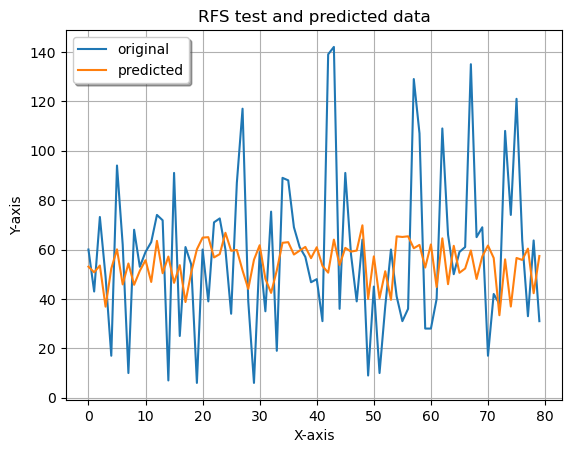

Lreg best param: {'fit_intercept': True}
Lreg MAE score: 25.004818467277044

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits


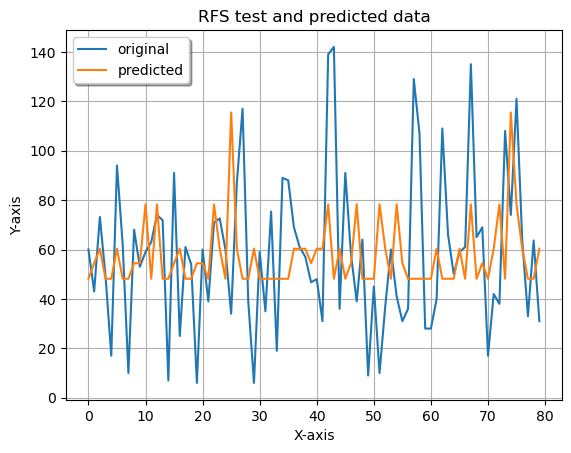

DTreg best param: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3}
DTreg MAE score: 26.24872320557613

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits


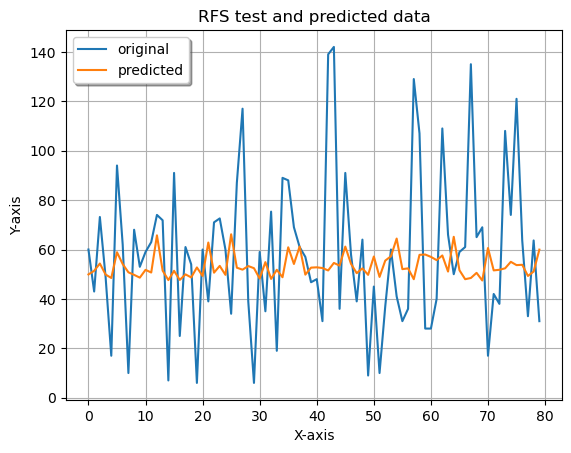

SVMreg best param: {'C': 3, 'gamma': 1.0, 'kernel': 'rbf'}
SVMreg MAE score: 25.103281218877044

--------------------------------------------------------
bestModel: GridSearchCV(cv=KFold(n_splits=10, random_state=8, shuffle=True),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]}, verbose=1)
bestParam: {'fit_intercept': True}
bestScore: 25.004818467277044


In [42]:
""" Markov Blanket GBR nested cross validation """

def cross_val(estimator, X_train, y_train, parameters, inner_cv, outer_cv):
    best_model = None
    best_params = None
    best_score = 100
    for train, test in outer_cv.split(X_train):
        # training and validation
        X_outer_train = X_train[train]
        y_outer_train = y_train[train]
        X_outer_test = X_train[test]
        y_outer_test = y_train[test]

        model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=None, verbose=1)
        #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=5, verbose=3)
        model.fit(X_outer_train, y_outer_train)
        # evaluate the accuracy of each fold
        prediction = model.predict(X_outer_test)
        score = metrics.mean_absolute_error(y_outer_test, prediction) # use mse as metrics in K-fold, np.array(y_test), verbose=0)

        if best_score > score:
            best_score = score
            best_model = model
            best_params = model.best_params_
    return best_score, best_model, best_params

def plot_draw(y_best, y_pred):
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)    
bestModel_markov_gbr = None
bestParam_markov_gbr = None
bestScore_markov_gbr = 100

################################################################################

#hyper parameter tuning for LinearRegression
lreg_parameters = {"fit_intercept":[True,False]}

## call model
Lreg = linear_model.LinearRegression()

train_score, estimator, param = cross_val(Lreg, X_train, y_train, lreg_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "Lreg_pca_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore_markov_gbr:
    bestModel_markov_gbr = estimator
    bestScore_markov_gbr = score
    bestParam_markov_gbr = param

# print("Lreg trained MAE best score: {}".format(train_score))
print("Lreg best param: {}".format(param))
# print("Lreg best estimator: {}".format(estimator))
print("Lreg MAE score: {}\n".format(score))


################################################################################

#hyper parameter tuning for Decision Tree
dt_parameters = {"max_depth" : [3,9,12],
           "min_samples_leaf":[3,6,9],
           "max_features":["auto","log2","sqrt",None]}

## call model
DTreg = DecisionTreeRegressor()

train_score, estimator, param = cross_val(DTreg, X_train, y_train, dt_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "DTreg_nested_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore_markov_gbr:
    bestModel_markov_gbr = estimator
    bestScore_markov_gbr = score
    bestParam_markov_gbr = param

# print("DTreg trained MAE best score: {}".format(train_score))
print("DTreg best param: {}".format(param))
# print("DTreg best estimator: {}".format(estimator))
print("DTreg MAE score: {}\n".format(score))

################################################################################

#hyper parameter tuning for SVM
svm_parameters = {"kernel":['rbf', 'sigmoid'],
           "gamma":[0.1,1.0,10.0,'scale','auto'],
           "C": [1,2,3,4,5,6]}

## call model
SVMreg = svm.SVR()

train_score, estimator, param = cross_val(SVMreg, X_train, y_train, svm_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "SVMreg_nested_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore_markov_gbr:
    bestModel_markov_gbr = estimator
    bestScore_markov_gbr = score
    bestParam_markov_gbr = param

# print("SVMreg trained MAE best score: {}".format(train_score))
print("SVMreg best param: {}".format(param))
# print("SVMreg best estimator: {}".format(estimator))
print("SVMreg MAE score: {}\n".format(score))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel_markov_gbr))
print("bestParam: {}".format(bestParam_markov_gbr))
print("bestScore: {}".format(bestScore_markov_gbr))

In [43]:
## Markov Blanket ANN sklearn
np.warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import random

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

best_score = 100
best_model = None
outerLoop = KFold(n_splits=10)
innerLoop = KFold(n_splits=10)

outerK = 0

for outter_train_index, outter_test_index in outerLoop.split(X_train):

    #print("outer K: ",(outerK+1))
    outerK += 1
    X_total_train, X_total_test = X_train[outter_train_index], X_train[outter_test_index]
    y_total_train, y_total_test = y_train[outter_train_index], y_train[outter_test_index]

    param_mlpr = {   
                    'hidden_layer_sizes' : [(4,3,2),(4),(4,3)],
                    'activation' : ['identity','logistic','tanh','relu'],
                    "random_state" : range(0, 50),
                    'batch_size' : [5,10],
                    'alpha' : [0.0001, 0.001, 0.01],
                    'solver' : ['sgd','adam', 'lbfgs'],
                    'learning_rate' : ['constant','invscaling'],
                    }
    #find the best parameter tunning
    #to be implemented

    grid = RandomizedSearchCV(MLPRegressor(max_iter= 2000),param_mlpr,cv=innerLoop,refit=True,verbose=1,n_iter= 3)
    model = grid.fit(X_total_train, y_total_train)

    #fit the model using the best parameter
    y_pred = model.predict(X_total_test)
    score = metrics.mean_absolute_error(y_total_test, y_pred)

    #keep a reference of the best model for further usage
    if(score < best_score):
        best_score = score
        best_model = model

y_pred = best_model.predict(X_test)
score = metrics.mean_absolute_error(y_test, y_pred)
# joblib.dump(bestModel, "ANNreg_nested_markov_dt.pkl")

if score < bestScore_markov_gbr:
    bestModel_markov_gbr = best_model
    bestScore_markov_gbr = score
    bestParam_markov_gbr = best_model.best_params_

print("Best Model MAE: {}".format(score))
print("Best Model Parameters: {}".format(best_model.best_params_))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel_markov_gbr))
print("bestParam: {}".format(bestParam_markov_gbr))
print("bestScore: {}".format(bestScore_markov_gbr))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Model MAE: 24.07739852855752
Best Model Parameters: {'solver': 'adam', 'random_state': 12, 'learning_rate': 'constant', 'hidden_layer_sizes': 4, 'batch_size': 5, 'alpha': 0.01, 'activation': 'logistic'}
--------------------------------------------------------
bestModel: RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=MLPRegres

Epoch 1/30
9/9 [==============================] - 1s 23ms/step - loss: 55.9566 - val_loss: 62.0144
Epoch 2/30
9/9 [==============================] - 0s 7ms/step - loss: 55.9566 - val_loss: 62.0144
Epoch 3/30
9/9 [==============================] - 0s 7ms/step - loss: 55.9566 - val_loss: 62.0144
Epoch 4/30
9/9 [==============================] - 0s 4ms/step - loss: 55.9566 - val_loss: 62.0144
Epoch 5/30
9/9 [==============================] - 0s 4ms/step - loss: 55.9566 - val_loss: 62.0144
Epoch 6/30
9/9 [==============================] - 0s 3ms/step - loss: 55.9566 - val_loss: 62.0144
Epoch 7/30
9/9 [==============================] - 0s 3ms/step - loss: 55.9566 - val_loss: 62.0144
Epoch 8/30
9/9 [==============================] - 0s 4ms/step - loss: 55.9566 - val_loss: 62.0144
Epoch 9/30
9/9 [==============================] - 0s 4ms/step - loss: 55.9566 - val_loss: 62.0144
Epoch 10/30
9/9 [==============================] - 0s 3ms/step - loss: 55.9566 - val_loss: 62.0144
Epoch 11/30
9/9 [=

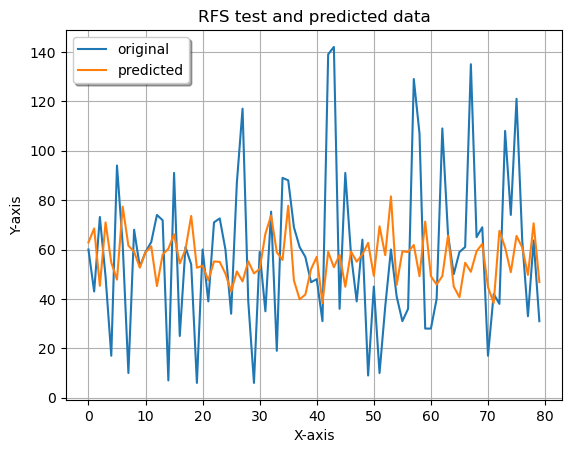

Annreg MAE score: 24.75739248593648
Annreg best estimator: <keras.engine.sequential.Sequential object at 0x7f9f71660a10>

--------------------------------------------------------
bestModel: RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=MLPRegressor(max_iter=2000), n_iter=3,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'batch_size': [5, 10],
                                        'hidden_layer_sizes': [(4, 3, 2), 4,
                                                               (4, 3)],
                                        'learning_rate': ['constant',
                                                          'invscaling'],
                                        'random_state': range(0, 50),
                  

In [44]:
## Markov Blanket GBR ANN keras
import random

def plot_draw(y_best, y_pred):
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scores = []
best_estimator = []
best_params = {}
best_score = 100
k=1
for train, test in outer_cv.split(X_train):
    # training and validation
    X_outer_train = X_train[train]
    y_outer_train = y_train[train]
    X_outer_test = X_train[test]
    y_outer_test = y_train[test]

    activation = ['relu','tanh','sigmoid', 'exponential', 'softmax', 'softplus','softsign','selu','elu']
    ANNreg = Sequential()  
    # Defining the Input layer and FIRST hidden layer, both are same!
    ANNreg.add(Dense(random.randint(0,19), input_dim=19,kernel_initializer='normal', activation = activation[random.randint(0,8)]))
    #Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    ANNreg.add(Dense(random.randint(0,19), kernel_initializer='normal', activation=activation[random.randint(0,8)]))
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    ANNreg.add(Dense(random.randint(0,19), kernel_initializer='normal', activation=activation[random.randint(0,8)]))
    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    ANNreg.add(Dense(1, kernel_initializer='normal', activation=activation[random.randint(0,3)]))
    # Compile model
    ANNreg.compile(optimizer = 'adam', loss ='mean_absolute_error')
    ANNreg.save_weights('model.h5')

    #model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=2, verbose=3)
    #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=500, verbose=3)
    for inner_train_index, inner_validation_index in inner_cv.split(X_outer_train):
        X_inner_train, X_validation = X_outer_train[inner_train_index], X_outer_train[inner_validation_index]
        y_inner_train, y_validation = y_outer_train[inner_train_index], y_outer_train[inner_validation_index]
        ANNreg.load_weights('model.h5')
        model = ANNreg.fit(X_inner_train,
                        y_inner_train, 
                        epochs = 30, 
                        validation_data=(X_validation,y_validation))
        # evaluate the accuracy of each fold
        prediction = ANNreg.predict(X_outer_test)
        score = metrics.mean_absolute_error(y_outer_test, prediction) # use mse as metrics in K-fold, y_test), verbose=0)
        #scores.append(score)
        # scores = ann.evaluate(X_test,np.array(y_test), verbose=0)

        if best_score >= score:
            best_score = score
            # y_best = y_test
            # y_pred = prediction
            best_estimator = model
            ANNreg.save("ANN_model_Markov_gbr_pca")
            #best_params = model.best_params_
    print("OuterLoop {} - Annreg MAE score: {}".format(k, best_score))
    k+=1

model = keras.models.load_model('ANN_model_Markov_gbr_pca')
y_pred = model.predict(X_test)
score = metrics.mean_absolute_error(y_test, y_pred)
plot_draw(y_test, y_pred)

if score < bestScore_markov_gbr:
    bestModel_markov_gbr = model
    bestScore_markov_gbr = score
    bestParam_markov_gbr = 'ANN keras'

print("Annreg MAE score: {}".format(score))
print("Annreg best estimator: {}\n".format(model))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel_markov_gbr))
print("bestParam: {}".format(bestParam_markov_gbr))
print("bestScore: {}".format(bestScore_markov_gbr))


In [45]:
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel_markov_svr))
print("bestParam: {}".format(bestParam_markov_svr))
print("bestScore: {}".format(bestScore_markov_svr))

--------------------------------------------------------
bestModel: <keras.engine.sequential.Sequential object at 0x7f9f45704610>
bestParam: ANN keras
bestScore: 23.939497900009155


---
# RSF 

In [46]:
## Regression based on RSF
from sklearn.feature_selection import SelectFromModel
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import RandomizedSearchCV
# pip install scikit-survival
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

In [47]:
def y_dataframe_to_rsf_input(y_df):
    """
    Input for random survival forest.
    :param y_df: event + survival time dataframe.
    :return:
    """
    y_array = []
    Y = y_df.to_numpy()
    for y in Y:
        tuple = (bool(y[1]), y[0])
        y_array.append(tuple)
    return np.array(y_array, dtype = [(f'{y_df.columns[1]}', np.bool), (f'{y_df.columns[0]}', np.float)])

In [48]:
y = df_pca.loc[:, ['Y_clf', 'Y_reg']]
X = df_pca.drop(['Y_clf','Y_reg'], axis=1)
X = X.to_numpy()
y = y_dataframe_to_rsf_input(y)
tuned_params = {"n_estimators": [10, 50, 100, 200, 500],
                "min_samples_split": [2, 5, 10, 20, 40],
                "min_samples_leaf": [1, 2, 4, 8, 16]
                }
search = RandomizedSearchCV(RandomSurvivalForest(), tuned_params, cv=5, verbose=1, n_jobs=None, n_iter=50)
search.fit(X, y)

params = search.best_params_
rsf = RandomSurvivalForest(n_estimators = params['n_estimators'],
                           min_samples_split = params['min_samples_split'],
                           min_samples_leaf = params['min_samples_leaf'],
                           max_features="sqrt",
                           n_jobs=-1
                           )
cross_validate(rsf, X, y, cv=5)

perm = PermutationImportance(rsf, cv=5)
perm.fit(X, y)

##############################################################

sel = SelectFromModel(perm, prefit=True)
X_best = sel.transform(X)
id_features = sel.get_support(indices=True)
feature_name = list(df_pca.drop(['Y_clf', 'Y_reg'], axis=1).columns.values)
best_features = [feature_name[id] for id in id_features]
for id in id_features:
    print(f'{feature_name[id]}: {perm.feature_importances_[id]} +/- {perm.feature_importances_std_[id]}')
best_indices = np.flip(np.argsort(perm.feature_importances_))[:len(best_features)]
[feature_name[i] for i in np.argsort(best_indices)] 

from sklearn.model_selection import cross_validate
X_best = sel.transform(X)
cross_validate(rsf, X_best, y, cv=5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
ER: 0.010761205974754851 +/- 0.010749035457561866
HER2: 0.020500456396439652 +/- 0.010680781448410913
ChemoGrade: 0.0029930115686983916 +/- 0.0022959870410929994
Proliferation: 0.00955454713148645 +/- 0.010879559522878413
LNStatus: 0.005300929593382975 +/- 0.0074216152180549685
original_shape_Sphericity: 0.003009901112961275 +/- 0.0068904812474097285
original_firstorder_10Percentile: 0.005199072947483567 +/- 0.007071793455442283
original_firstorder_InterquartileRange: 0.0033730953872822766 +/- 0.006066556049885844
original_firstorder_Mean: 0.0046551991648269685 +/- 0.00576630159511661
original_firstorder_Uniformity: 0.0031112288909502617 +/- 0.005218620305469713
original_glcm_ClusterTendency: 0.0035949857679200958 +/- 0.005463647113396893
original_glcm_DifferenceEntropy: 0.0026081105669939443 +/- 0.005830361136960557
original_glcm_Imc2: -0.0023249023153309924 +/- 0.008760680973742966
original_glcm_SumEntropy: 0.0028381200156

libc++abi: libc++abi: libc++abi: terminating with uncaught exception of type std::runtime_error: Couldn't close fileterminating with uncaught exception of type std::runtime_error: Couldn't close fileterminating with uncaught exception of type std::runtime_error: Couldn't close file


exception calling callback for <Future at 0x7f9f83ef5690 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/yidan/opt/anaconda3/envs/mle_tf/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/Users/yidan/opt/anaconda3/envs/mle_tf/lib/python3.7/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/Users/yidan/opt/anaconda3/envs/mle_tf/lib/python3.7/site-packages/joblib/parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/yidan/opt/anaconda3/envs/mle_tf/lib/python3.7/site-packages/joblib/par

{'fit_time': array([1.82221985, 5.80014396, 0.81914806, 0.81213069, 0.79030609]),
 'score_time': array([0.        , 0.11170697, 0.10964084, 0.10915208, 0.10864615]),
 'test_score': array([       nan, 0.70361328, 0.73076923, 0.67789969, 0.61380145])}

In [ ]:
class RSFModel():

    def __init__(self, features):
        self.y_df = df_pca.loc[:, ['Y_clf', 'Y_reg']]
        self.X_df = df_pca.drop(['Y_clf', 'Y_reg'], axis=1)
        self.X = self.X_df.to_numpy()
        self.y = y_dataframe_to_rsf_input(self.y_df)

    def fine_tune(self, hyperparams):
        search = RandomizedSearchCV(RandomSurvivalForest(), tuned_params, cv=5, verbose=1, n_jobs=-1, n_iter=10)
        search.fit(self.X, self.y)
        return search.best_params_

    def cross_validate(self, params):
        params = search.best_params_
        rsf = RandomSurvivalForest(n_estimators = params['n_estimators'],
                                min_samples_split = params['min_samples_split'],
                                min_samples_leaf = params['min_samples_leaf'],
                                max_features="sqrt",
                                n_jobs=-1
                                )
        return np.mean(cross_validate(rsf, X, y, cv=5)['test_score'])


In [49]:
cols = [feature_name[id] for id in id_features]

print(len(cols))
X = df_pca[cols].values
#X = df_pca.drop(['Y_reg', 'Y_clf'], axis=1).values
y = df_pca['Y_reg'].values

38


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits


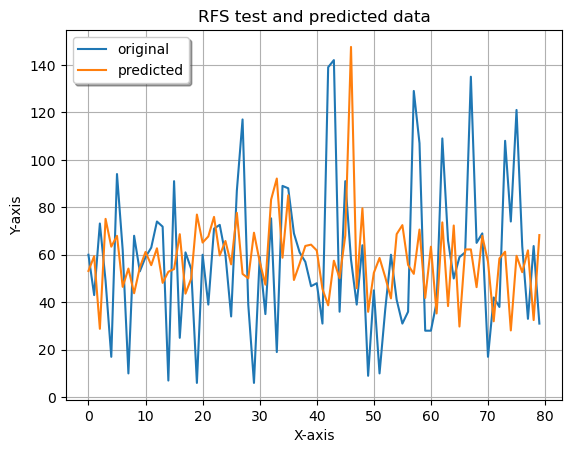

Lreg best param: {'fit_intercept': True}
Lreg MAE score: 27.4352278927962

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits


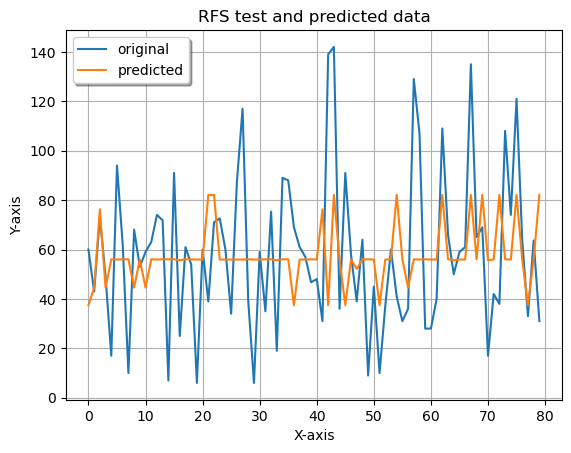

DTreg best param: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 9}
DTreg MAE score: 24.478262019334174

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits


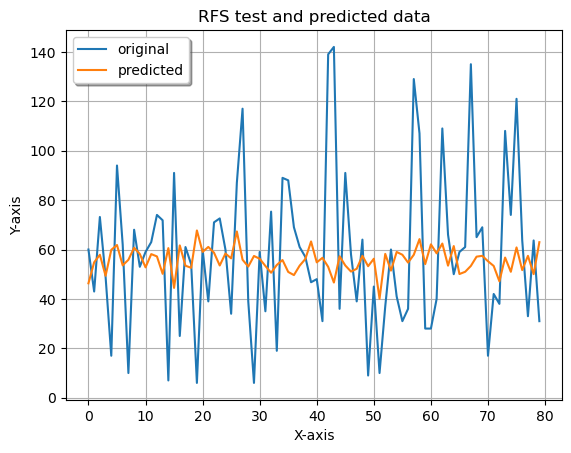

SVMreg best param: {'C': 6, 'gamma': 'scale', 'kernel': 'rbf'}
SVMreg MAE score: 24.953090966271592

--------------------------------------------------------
bestModel: GridSearchCV(cv=KFold(n_splits=10, random_state=8, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 9, 12],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'min_samples_leaf': [3, 6, 9]},
             verbose=1)
bestParam: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 9}
bestScore: 24.478262019334174


In [50]:
""" RSF nested cross validation """

def cross_val(estimator, X_train, y_train, parameters, inner_cv, outer_cv):
    best_model = None
    best_params = None
    best_score = 100
    for train, test in outer_cv.split(X_train):
        # training and validation
        X_outer_train = X_train[train]
        y_outer_train = y_train[train]
        X_outer_test = X_train[test]
        y_outer_test = y_train[test]

        model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=None, verbose=1)
        #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=5, verbose=3)
        model.fit(X_outer_train, y_outer_train)
        # evaluate the accuracy of each fold
        prediction = model.predict(X_outer_test)
        score = metrics.mean_absolute_error(y_outer_test, prediction) # use mse as metrics in K-fold, np.array(y_test), verbose=0)

        if best_score > score:
            best_score = score
            best_model = model
            best_params = model.best_params_
    return best_score, best_model, best_params

def plot_draw(y_best, y_pred):
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)    
bestModel_RSF = None
bestParam_RSF = None
bestScore_RSF = 100

################################################################################

#hyper parameter tuning for LinearRegression
lreg_parameters = {"fit_intercept":[True,False]}

## call model
Lreg = linear_model.LinearRegression()

train_score, estimator, param = cross_val(Lreg, X_train, y_train, lreg_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "Lreg_pca_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore_RSF:
    bestModel_RSF = estimator
    bestScore_RSF = score
    bestParam_RSF = param

# print("Lreg trained MAE best score: {}".format(train_score))
print("Lreg best param: {}".format(param))
# print("Lreg best estimator: {}".format(estimator))
print("Lreg MAE score: {}\n".format(score))


################################################################################

#hyper parameter tuning for Decision Tree
dt_parameters = {"max_depth" : [3,9,12],
           "min_samples_leaf":[3,6,9],
           "max_features":["auto","log2","sqrt",None]}

## call model
DTreg = DecisionTreeRegressor()

train_score, estimator, param = cross_val(DTreg, X_train, y_train, dt_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "DTreg_nested_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore_RSF:
    bestModel_RSF = estimator
    bestScore_RSF = score
    bestParam_RSF = param

# print("DTreg trained MAE best score: {}".format(train_score))
print("DTreg best param: {}".format(param))
# print("DTreg best estimator: {}".format(estimator))
print("DTreg MAE score: {}\n".format(score))

################################################################################

#hyper parameter tuning for SVM
svm_parameters = {"kernel":['rbf', 'sigmoid'],
           "gamma":[0.1,1.0,10.0,'scale','auto'],
           "C": [1,2,3,4,5,6]}

## call model
SVMreg = svm.SVR()

train_score, estimator, param = cross_val(SVMreg, X_train, y_train, svm_parameters, inner_cv, outer_cv)
# joblib.dump(estimator, "SVMreg_nested_markov_dt.pkl")

y_pred = estimator.predict(X_test)
score = metrics.mean_absolute_error(y_test,y_pred)
plot_draw(y_test, y_pred)

if score < bestScore_RSF:
    bestModel_RSF = estimator
    bestScore_RSF = score
    bestParam_RSF = param

# print("SVMreg trained MAE best score: {}".format(train_score))
print("SVMreg best param: {}".format(param))
# print("SVMreg best estimator: {}".format(estimator))
print("SVMreg MAE score: {}\n".format(score))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel_RSF))
print("bestParam: {}".format(bestParam_RSF))
print("bestScore: {}".format(bestScore_RSF))

In [51]:
## Markov Blanket ANN sklearn
np.warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import random

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

best_score = 100
best_model = None
outerLoop = KFold(n_splits=10)
innerLoop = KFold(n_splits=10)

outerK = 0

for outter_train_index, outter_test_index in outerLoop.split(X_train):

    #print("outer K: ",(outerK+1))
    outerK += 1
    X_total_train, X_total_test = X_train[outter_train_index], X_train[outter_test_index]
    y_total_train, y_total_test = y_train[outter_train_index], y_train[outter_test_index]

    param_mlpr = {   
                    'hidden_layer_sizes' : [(7,5,3),(5),(7,5)],
                    'activation' : ['identity','logistic','tanh','relu'],
                    "random_state" : range(0, 50),
                    'batch_size' : [5,10],
                    'alpha' : [0.0001, 0.001, 0.01],
                    'solver' : ['sgd','adam', 'lbfgs'],
                    'learning_rate' : ['constant','invscaling'],
                    }
    #find the best parameter tunning
    #to be implemented

    grid = RandomizedSearchCV(MLPRegressor(max_iter= 2000),param_mlpr,cv=innerLoop,refit=True,verbose=1,n_iter= 3)
    model = grid.fit(X_total_train, y_total_train)

    #fit the model using the best parameter
    y_pred = model.predict(X_total_test)
    score = metrics.mean_absolute_error(y_total_test, y_pred)

    #keep a reference of the best model for further usage
    if(score < best_score):
        best_score = score
        best_model = model

y_pred = best_model.predict(X_test)
score = metrics.mean_absolute_error(y_test, y_pred)
# joblib.dump(bestModel, "ANNreg_nested_markov_dt.pkl")

if score < bestScore_RSF:
    bestModel_RSF = best_model
    bestScore_RSF = score
    bestParam_RSF = best_model.best_params_

print("Best Model MAE: {}".format(score))
print("Best Model Parameters: {}".format(best_model.best_params_))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel_RSF))
print("bestParam: {}".format(bestParam_RSF))
print("bestScore: {}".format(bestScore_RSF))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Model MAE: 24.066580728614404
Best Model Parameters: {'solver': 'lbfgs', 'random_state': 40, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (7, 5, 3), 'batch_size': 5, 'alpha': 0.0001, 'activation': 'tanh'}
--------------------------------------------------------
bestModel: RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator

Epoch 1/30
9/9 [==============================] - 2s 36ms/step - loss: 55.9345 - val_loss: 61.9808
Epoch 2/30
9/9 [==============================] - 0s 4ms/step - loss: 55.9153 - val_loss: 61.9614
Epoch 3/30
9/9 [==============================] - 0s 9ms/step - loss: 55.8957 - val_loss: 61.9413
Epoch 4/30
9/9 [==============================] - 0s 5ms/step - loss: 55.8754 - val_loss: 61.9204
Epoch 5/30
9/9 [==============================] - 0s 6ms/step - loss: 55.8539 - val_loss: 61.8981
Epoch 6/30
9/9 [==============================] - 0s 4ms/step - loss: 55.8311 - val_loss: 61.8744
Epoch 7/30
9/9 [==============================] - 0s 7ms/step - loss: 55.8067 - val_loss: 61.8488
Epoch 8/30
9/9 [==============================] - 0s 6ms/step - loss: 55.7804 - val_loss: 61.8212
Epoch 9/30
9/9 [==============================] - 0s 4ms/step - loss: 55.7520 - val_loss: 61.7914
Epoch 10/30
9/9 [==============================] - 0s 3ms/step - loss: 55.7214 - val_loss: 61.7598
Epoch 11/30
9/9 [=

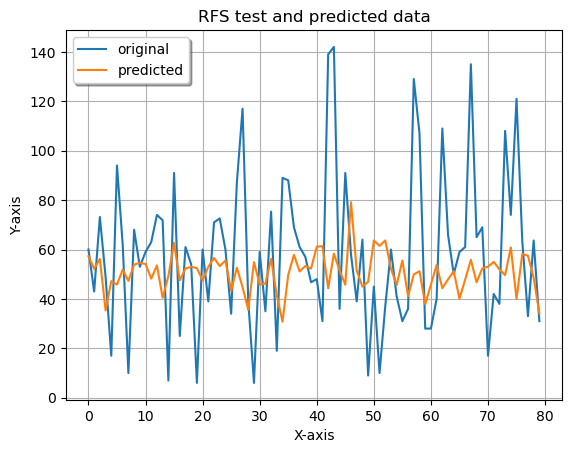

Annreg MAE score: 25.157687425613403
Annreg best estimator: <keras.engine.sequential.Sequential object at 0x7f9f71ca5090>

--------------------------------------------------------
bestModel: RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=MLPRegressor(max_iter=2000), n_iter=3,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'batch_size': [5, 10],
                                        'hidden_layer_sizes': [(7, 5, 3), 5,
                                                               (7, 5)],
                                        'learning_rate': ['constant',
                                                          'invscaling'],
                                        'random_state': range(0, 50),
                 

In [52]:
## RSF ANN keras
import random

def plot_draw(y_best, y_pred):
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scores = []
best_estimator = []
best_params = {}
best_score = 100
k=1
for train, test in outer_cv.split(X_train):
    # training and validation
    X_outer_train = X_train[train]
    y_outer_train = y_train[train]
    X_outer_test = X_train[test]
    y_outer_test = y_train[test]

    activation = ['relu','tanh','sigmoid', 'exponential', 'softmax', 'softplus','softsign','selu','elu']
    ANNreg = Sequential()  
    # Defining the Input layer and FIRST hidden layer, both are same!
    ANNreg.add(Dense(random.randint(0,38), input_dim=38,kernel_initializer='normal', activation = activation[random.randint(0,8)]))
    #Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    ANNreg.add(Dense(random.randint(0,38), kernel_initializer='normal', activation=activation[random.randint(0,8)]))
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    ANNreg.add(Dense(random.randint(0,38), kernel_initializer='normal', activation=activation[random.randint(0,8)]))
    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    ANNreg.add(Dense(1, kernel_initializer='normal', activation=activation[random.randint(0,3)]))
    # Compile model
    ANNreg.compile(optimizer = 'adam', loss ='mean_absolute_error')
    ANNreg.save_weights('model.h5')

    #model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=2, verbose=3)
    #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=500, verbose=3)
    for inner_train_index, inner_validation_index in inner_cv.split(X_outer_train):
        X_inner_train, X_validation = X_outer_train[inner_train_index], X_outer_train[inner_validation_index]
        y_inner_train, y_validation = y_outer_train[inner_train_index], y_outer_train[inner_validation_index]
        ANNreg.load_weights('model.h5')
        model = ANNreg.fit(X_inner_train,
                        y_inner_train, 
                        epochs = 30, 
                        validation_data=(X_validation,y_validation))
        # evaluate the accuracy of each fold
        prediction = ANNreg.predict(X_outer_test)
        score = metrics.mean_absolute_error(y_outer_test, prediction) # use mse as metrics in K-fold, y_test), verbose=0)
        #scores.append(score)
        # scores = ann.evaluate(X_test,np.array(y_test), verbose=0)

        if best_score >= score:
            best_score = score
            # y_best = y_test
            # y_pred = prediction
            best_estimator = model
            ANNreg.save("ANN_model_RSF_pca")
            #best_params = model.best_params_
    print("OuterLoop {} - Annreg MAE score: {}".format(k, best_score))
    k+=1

model = keras.models.load_model('ANN_model_RSF_pca')
y_pred = model.predict(X_test)
score = metrics.mean_absolute_error(y_test, y_pred)
plot_draw(y_test, y_pred)

if score < bestScore_RSF:
    bestModel_RSF = model
    bestScore_RSF = score
    bestParam_RSF = 'ANN keras'

print("Annreg MAE score: {}".format(score))
print("Annreg best estimator: {}\n".format(model))

############################################################
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel_RSF))
print("bestParam: {}".format(bestParam_RSF))
print("bestScore: {}".format(bestScore_RSF))


In [51]:
print("--------------------------------------------------------")
print("bestModel: {}".format(bestModel_RSF))
print("bestParam: {}".format(bestParam_RSF))
print("bestScore: {}".format(bestScore_RSF))

joblib.dump(bestModel_RSF, 'bestModel_RSF.pkl')

--------------------------------------------------------
bestModel: GridSearchCV(cv=KFold(n_splits=10, random_state=8, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [1, 2, 3, 4, 5, 6],
                         'gamma': [0.1, 1.0, 10.0, 'scale', 'auto'],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=1)
bestParam: {'C': 5, 'gamma': 0.1, 'kernel': 'sigmoid'}
bestScore: 21.52227873395004


['bestModel_RSF.pkl']

---
# RRelifF

In [53]:
# ## This one is not suitable for Regression feature selection

# import sklearn_relief as sr
# from sklearn.preprocessing import MinMaxScaler
# # data_RReliefF,Y3 = dataFrame.drop(columns ='RelapseFreeSurvival (outcome)').values, dataFrame['RelapseFreeSurvival (outcome)'].values

# data_RReliefF,Y3 = df_pca.drop(columns =['Y_clf', 'Y_reg']).values, df['Y_reg'].values
# r = sr.RReliefF(n_features = 20)
# my_transformed_matrix = r.fit_transform(data_RReliefF,Y3)
# feature_names = list(df_pca.drop(columns =['Y_clf', 'Y_reg']))
# indexes = []
# for value in my_transformed_matrix[0]:
#     for idx, origVal in enumerate(data_RReliefF[0]):
#         if(value == origVal):
#             if feature_names[idx] not in indexes:
#                 indexes.append((feature_names[idx]))
#             break
# print(indexes)


In [ ]:
# rrelieff_cols = ['TumourStage', 'ER', 'TrippleNegative', 'original_shape_Sphericity', 
# 'original_glszm_GrayLevelVariance', 'original_glszm_GrayLevelNonUniformityNormalized', 
# 'original_shape_Flatness', 'original_firstorder_Median', 'original_firstorder_Minimum', 
# 'original_shape_Elongation', 'ChemoGrade', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum2DDiameterRow']

# print(len(rrelieff_cols))
# X = df_pca[rrelieff_cols].values
# #X = df_pca.drop(['Y_reg', 'Y_clf'], axis=1).values
# y = df_pca['Y_reg'].values

13
